# CNN Based Image Segmentation of DICOM Images - Training
### **```Author : BlackViper42```**
______

Overview
======

------
 - This notebook consists of HeadRest Segmentation of CT Scan DICOM images of head patients downloaded from server of anonymous patients. 
 
 
 - Currently this notebook predicts the segmented image of original `input_image` and this can be further taken to get `output_image` without headrest by multiplying `predicted_outcome` (binary labeled image) with `input_image`.
 
 
 - Prerequisites for this notebook:
    - Graphics Card -------------------------------  NVIDIA  Quadro M5000 - 8GB 
    - `CUDA` toolkit 7.0 or above -------------------  installed  CUDA-8.0
    - `cuDNN` 5.1 or above --------------------------  installed  cuDNN-5.1 
    - `tensorflow-gpu` library
 
 - [please go through this link for installation of tensorflow-gpu](https://www.tensorflow.org/install/install_linux)
 - [Tensorflow implementation of Image Segmentation on Python](https://github.com/jakeret/tf_unet)
 
 
 - If you want to run this notebook without GPUs then install `tensorflow` library and comment these lines:
 
 ```python
 config = tf.ConfigProto()
 config.gpu_options.allow_growth = True``` 
  and change
  ```python
  tf.Session(config=config)```
  by 
  ```python
  tf.Session()```
 - In order to check whether GPU is correctly called by tensorflow run this line:
 ```python
 from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()```
and check the output you got on `terminal` where you initialized `Jupyter notebook`. If your output shows `(/gpu:0)` in last line then it is correct. If you are using Non-GPU tensorflow then your output should be `(/cpu:0)`.


Project Description
======

______

### Data
 - Input data consists of 2D dicom format images of ** 512*512 ** pixels of various patients. Input dataset reffered here as **`train_images_input`** contains 2490 images with grayscale values. 
 - Labelled data consists of binary indicated images of **0s** and **1s** where **1s** tells presence of headrest and **0s** tells background without headrest.

### Model
 - Model built here is 7 layer Convolutional nueral networks with pooling and upsampling. Below is the structure of network:
 
 - Parameters which are used in this model:
 
 
| Parameter        | Value           | 
| ------------- |:-------------:| 
| Filter size   | **`3*3`**   |
| Pool size    | **`2*2`**   |
| Zero Padding  | **`1`**  |
| Padding    | **`VALID`**   |
| Cost Function      | **`Softmax Cross Entropy`** | 
| Optimizer      |  **`Momentum`**    |  
| Epocs | **`150`**      | 
| Training Iterations     | **`50`** |
| Learning Rate        |  **`0.2`**  |
| Decay Rate         |  **`0.95`**   |



 - Accuracy is calculated on pixel wise correct classification of an image. 
 - Predictions after each epoc is stored in **`prediction_model_50_500_3`** folder.
 - Model outputs are stored in pickel format in **`unet_trained_50_500_3`** folder.

______
## ``` Importing Libraries```

In [45]:
from __future__ import division, print_function,absolute_import, unicode_literals
%matplotlib inline
import matplotlib.pyplot as plt                                    ##...Plotting libraries
import matplotlib                                                  
import numpy as np                                                 ##...for mathematical operations
import glob                                                        ##...for importing directories and paths
from PIL import Image                                              ##...for saving images
import os
import shutil
from glob import glob
from collections import OrderedDict
import logging                                                     ##...for making logs on progress based on real time
import tensorflow as tf                                            ##...for building Convolutional Neural Networks 
import dicom
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from matplotlib.patches import Ellipse
from skimage import io, color, measure, draw, img_as_bool
from scipy import optimize
import pandas as pd
from skimage import color

In [46]:
from tensorflow.python.client import device_lib                    ##...to check whether GPU is called properly or not
local_device_protos = device_lib.list_local_devices()

In [47]:
config = tf.ConfigProto()                                          ##...to allow bfc::Allocator provide more than default 
config.gpu_options.allow_growth = True                             ##...memory  to GPU

______
## ``` Importing Data :: Preprocessing```

> This data is preprocessed in **```Segmentation_headrest_label.ipynb```** 

> Importing Data stored in numpy arrays using **```np.load()```**

> Offsetting the **```grayscale values```** by **```1024 HU units```** to make all values positive.

In [5]:
train_images_input = np.load('/home/ctuser/Desktop/Semantic_Seg/datatrain_images_input__big_masked_2.npy')
ground_truth_images = np.load('/home/ctuser/Desktop/Semantic_Seg/datatrain_images_groundtruth_big_masked_2.npy')

In [6]:
offset = np.ones_like(train_images_input,dtype=np.float32)
offset = offset*1024.

In [7]:
train_images_input+=offset
#train_images_input = train_images_input.astype('float32')
#ground_truth_images = ground_truth_images.astype('float32')

In [8]:
offset=1 ## to free up the space 

> Creating Training and testing Sample data for future using **```train_test_split```** function.

In [8]:
## data_train, data_test, labels_train, labels_test = train_test_split(train_images_input,
##                                                                   ground_truth_images, test_size=0.20,random_state=42) 

In [9]:
## training data and labels = data_train, labels_train
## testing data and labels = data_test, labels_test

> Creating Class - **```BaseDataProvider```** for importing data and making **```4D Tensors```** and giving batch-wise output when called.

> Parameter here is **```n```** - Number of randomly sample data you want to call in **```4D Tensor```** format.

In [9]:
class BaseDataProvider(object):
    """
    This class is used to import, preprocessing of data
    before feeding into Convolutional neural networks.
    It also create labels into same fashion.
    """
    
    #channels = 1
    #n_class = 2
    def __init__(self,data,label,a_min=None,a_max=None,channels =1,n_class =2):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_max is not None else np.inf
        self.data = data
        self.label = label
        self.file_count = data.shape[0]
        self.n_class=n_class
        self.channels = channels
    
    def _next_data(self):
        idx = np.random.choice(self.file_count)
        return self.data[idx], self.label[idx]
    
    def _load_data_and_label(self):
        data, label = self._next_data()
        
        train_data = self._process_data(data)
        labels = self._process_labels(label)
        
        train_data, labels = self._postprocess_data(train_data, labels)
        
        nx = data.shape[1]
        ny = data.shape[0]
        
        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class)
    
    def _process_labels(self, label):
        if self.n_class==2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny,nx,self.n_class),dtype=np.float32)
            one = np.ones_like(labels[...,0],dtype=np.float32)
            labels[...,0] = one - label
            labels[...,1] = label
            return labels
        
        return label
    
    def _process_data(self, data):
        data = np.clip(data, self.a_min, self.a_max)
        data = data-np.amin(data)    
        data = data/np.amax(data)
        return data
    
    def _postprocess_data(self,data,labels):
        """
        Post processing can be done to make it more easier 
        for CNN to work and give better accuracy.
        
        """
        return data, labels
    
    def __call__(self,n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]
        
        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))
        
        X[0] = train_data
        Y[0] = labels
        
        for i in range(1,n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels
            
        
        return X, Y

In [10]:
class BaseDataProvidertest(object):
    """
    This class is used to import, preprocessing of data
    before feeding into Convolutional neural networks.
    It also create labels into same fashion.
    """
    
    #channels = 1
    #n_class = 2
    def __init__(self,data,a_min=None,a_max=None,channels =1,n_class =2):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_max is not None else np.inf
        self.data = data
        self.file_count = data.shape[0]
        self.n_class=n_class
        self.channels = channels
    
    def _next_data(self,i):
        #idx = np.random.choice(self.file_count)
        return self.data[i]
    
    def _load_data_and_label(self,i):
        data = self._next_data(i)
        
        train_data, min_data_i, max_data_i = self._process_data(data)
        
        train_data = self._postprocess_data(train_data)
        
        nx = data.shape[1]
        ny = data.shape[0]
        
        return train_data.reshape(1, ny, nx, self.channels), min_data_i, max_data_i
    
    def _process_data(self, data):
        data = np.clip(data, self.a_min, self.a_max)
        min_val = np.amin(data)
        max_val = np.amax(data)
        data = data-np.amin(data)    
        data = data/np.amax(data)
        return data, min_val, max_val
    
    def _postprocess_data(self,data):
        """
        Post processing can be done to make it more easier 
        for CNN to work and give better accuracy.
        
        """
        return data
    
    def __call__(self,n):
        i=0
        train_data, min_data_i, max_data_i = self._load_data_and_label(i)
        nx = train_data.shape[1]
        ny = train_data.shape[2]
        
        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, 2))
        X[0] = train_data
        Y[0, 0] = min_data_i
        Y[0, 1] = max_data_i
        for i in range(1,n):
            train_data, min_data_i, max_data_i = self._load_data_and_label(i)
            X[i] = train_data
            Y[i, 0] = min_data_i
            Y[i, 1] = max_data_i
            
        
        return X, Y

In [11]:
mydata_test = BaseDataProvidertest(data = train_images_input, channels=1, n_class=2)

In [12]:
X_test, min_max = mydata_test(5)

In [11]:
mydata = BaseDataProvider(data=train_images_input, label=ground_truth_images,channels=1,n_class=2)

In [12]:
## mydata_test = BaseDataProvider(data=data_test, label=labels_test,channels=1,n_class=2)

> Creating small sample in **```X_test, Y_test```** to check predictions on it once model is trained.

In [52]:
X_test, Y_test = mydata(50)

> **```Input image```** and its **```label```** looks like this: 

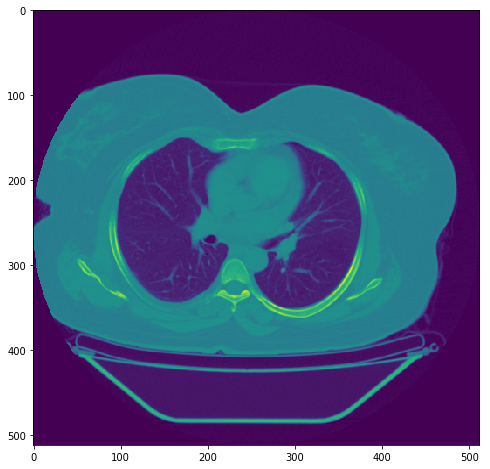

In [17]:
fig, ax = plt.subplots(1,1, sharey=True, figsize=(8,8))
ax.imshow(X_test[0,...,0], aspect="auto")
#ax[1].imshow(Y_test[0,...,0], aspect="auto")

> Importing Data from the given **```input_folder```**

In [7]:
data_path = "/home/ctuser/myData/s438/"              ##... insert the data_path
output_path = working_path = "/home/ctuser/Desktop/Semantic_Seg/data"
g = glob(data_path + "/*")

print("Total no. of CT images are: %d \nFirst 5 elements:" %len(g))
print ('\n'.join(g[:5]))

Total no. of CT images are: 34 
First 5 elements:
/home/ctuser/myData/s438/i36941.CTDC.20
/home/ctuser/myData/s438/i36953.CTDC.32
/home/ctuser/myData/s438/i36940.CTDC.19
/home/ctuser/myData/s438/i36922.CTDC.1
/home/ctuser/myData/s438/i36955.CTDC.34


> Loading CT Scan Images and calculate HU units for each pixels

> **```load_scan```** : loading all the image slices for each patient folder

> **```get_pixels_hu```** : Storing HU_units pixel array in **```numpy```** format for image processing


In [8]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=1000000
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

In [10]:
offset = np.ones_like(imgs,dtype=np.float32)
imgs = imgs.astype("float32")
offset = offset*1024.
imgs+=offset
offset=1

______
## **```Building Convolutional Networks```**

> Defining some functions which we will use in later part of notebook:
  - **```plot_prediction```** : takes ```test_data, labels, predictions``` and plot the images; can be used to save the output as well.
  - **```crop_to_shape```** : crop ```initial_tensor``` to ```final_tensor``` shape
  - **```to_rgb```** : convert given image to RGB format; not used here
  - **```error_rate```** : error of prediction in **%** format
  - **```get_image_summary```** : gives image summary 
  - **```combine_img_prediction ```** : Combines the data, grouth thruth and the prediction into one rgb image; amethod to visualize
  - **```save_image ```** : to save the image

In [18]:
def plot_prediction(x_test, y_test, prediction, save=False):
    import matplotlib
    import matplotlib.pyplot as plt
    
    test_size = x_test.shape[0]
    fig, ax = plt.subplots(test_size, 3, figsize=(12,12), sharey=True, sharex=True)
    ax = np.atleast_2d(ax)
    for i in range(test_size):
        cax = ax[i, 0].imshow(x_test[i,...,0])
        plt.colorbar(cax, ax=ax[i,0])
        cax = ax[i, 1].imshow(y_test[i, ..., 1])
        plt.colorbar(cax, ax=ax[i,1])
        pred = prediction[i, ..., 1]
        #pred -= np.amin(pred)                           ## recheck this :: might create some errors later.
        #pred /= np.amax(pred)
        cax = ax[i, 2].imshow(pred)
        plt.colorbar(cax, ax=ax[i,2])
        if i==0:
            ax[i, 0].set_title("x")
            ax[i, 1].set_title("y")
            ax[i, 2].set_title("pred")
    #fig.tight_layout()
    
    if save:
        fig.savefig(save)
    else:
        fig.show()
plt.show()

In [19]:
def crop_to_shape(data, shape):
    """
    Crops the array to the given image shape by removing the border (expects a tensor of shape [batches, nx, ny, channels].
    
    :param data: the array to crop
    :param shape: the target shape
    """
    offset0 = (data.shape[1] - shape[1])//2
    offset1 = (data.shape[2] - shape[2])//2
    if data.shape[1] == shape[1]:
        return data
    else:
        return data[:, offset0:(-offset0), offset1:(-offset1)]

In [20]:
def to_rgb(img):
    """
    Converts the given array into a RGB image. If the number of channels is not
    3 the array is tiled such that it has 3 channels. Finally, the values are
    rescaled to [0,255) 
    
    :param img: the array to convert [nx, ny, channels]
    
    :returns img: the rgb image [nx, ny, 3]
    """
    img = np.atleast_3d(img)
    channels = img.shape[2]
    if channels < 3:
        img = np.tile(img, 3)
    
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    img *= 255
    return img

In [21]:
def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """
    
    return 100.0 - (100.0 * np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
                    (predictions.shape[0]*predictions.shape[1]*predictions.shape[2]))

In [22]:
def get_image_summary(img, idx=0):
    """
    Make an image summary for 4d tensor image with index idx
    """
    
    V = tf.slice(img, (0, 0, 0, idx), (1, -1, -1, 1))
    V -= tf.reduce_min(V)
    V /= tf.reduce_max(V)
    V *= 255
    
    img_w = tf.shape(img)[1]
    img_h = tf.shape(img)[2]
    V = tf.reshape(V, tf.stack((img_w, img_h, 1)))
    V = tf.transpose(V, (2, 0, 1))
    V = tf.reshape(V, tf.stack((-1, img_w, img_h, 1)))
    return V

In [23]:
def combine_img_prediction(data, gt, pred):
    """
    Combines the data, grouth thruth and the prediction into one rgb image
    
    :param data: the data tensor
    :param gt: the ground thruth tensor
    :param pred: the prediction tensor
    
    :returns img: the concatenated rgb image 
    """
    ny = pred.shape[2]
    ch = data.shape[3]
    img = np.concatenate((to_rgb(crop_to_shape(data, pred.shape).reshape(-1, ny, ch)), 
                          to_rgb(crop_to_shape(gt[..., 1], pred.shape).reshape(-1, ny, 1)), 
                          to_rgb(pred[..., 1].reshape(-1, ny, 1))), axis=1)
    return img

def save_image(img, path):
    """
    Writes the image to disk
    
    :param img: the rgb image to save
    :param path: the target path
    """
    Image.fromarray(img.round().astype(np.uint8)).save(path, 'JPEG', dpi=[300,300], quality=90)

> **```layers initialization functions```**

In [24]:
def weight_variable(shape, stddev=0.1):
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial)

def weight_variable_devonc(shape, stddev=0.1):
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev))

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W,keep_prob_):
    conv_2d = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')
    return tf.nn.dropout(conv_2d, keep_prob_)

def deconv2d(x, W,stride):
    x_shape = tf.shape(x)
    output_shape = tf.stack([x_shape[0], x_shape[1]*2, x_shape[2]*2, x_shape[3]//2])
    return tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding='VALID')

def max_pool(x,n):
    return tf.nn.max_pool(x, ksize=[1, n, n, 1], strides=[1, n, n, 1], padding='VALID')

def crop_and_concat(x1,x2):
    x1_shape = tf.shape(x1)
    x2_shape = tf.shape(x2)
    # offsets for the top left corner of the crop
    offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
    size = [-1, x2_shape[1], x2_shape[2], -1]
    x1_crop = tf.slice(x1, offsets, size)
    return tf.concat([x1_crop, x2], 3)   

def pixel_wise_softmax(output_map):
    exponential_map = tf.exp(output_map)
    evidence = tf.add(exponential_map,tf.reverse(exponential_map,[False,False,False,True]))
    return tf.div(exponential_map,evidence, name="pixel_wise_softmax")

def pixel_wise_softmax_2(output_map):
    exponential_map = tf.exp(output_map)
    sum_exp = tf.reduce_sum(exponential_map, 3, keep_dims=True)
    tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1, tf.shape(output_map)[3]]))
    return tf.div(exponential_map,tensor_sum_exp)

def cross_entropy(y_,output_map):
    return -tf.reduce_mean(y_*tf.log(tf.clip_by_value(output_map,1e-10,1.0)), name="cross_entropy")
#     return tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(output_map), reduction_indices=[1]))

In [25]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')  ## to get log of real time and progress

______
## **```Model Training```**

>  **```Model_1```** : layers=5 with 2 Convolutional layer each

In [26]:
def create_conv_net_1(x, keep_prob, channels, n_class, layers=5, features_root=16, filter_size=3, pool_size=2, summaries=False):
    """
    Creates a new convolutional unet for the given parametrization.
    
    :param x: input tensor, shape [?,nx,ny,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    :param summaries: Flag if summaries should be created
    """
    
    logging.info("Layers {layers}, features {features}, filter size {filter_size}x{filter_size},pool size: {pool_size}x{pool_size}".format(layers=layers,
                                                                                                           features=features_root,
                                                                                                           filter_size=filter_size,
                                                                                                           pool_size=pool_size))
    # Placeholder for the input image
    nx = tf.shape(x)[1]
    ny = tf.shape(x)[2]
    x_image = tf.reshape(x, tf.stack([-1,nx,ny,channels]))
    in_node = x_image
    batch_size = tf.shape(x_image)[0]
 
    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()
    paddings=[[0,0],[1,1],[1,1],[0,0]]
    in_size = 1000
    size = in_size
    # down layers
    for layer in range(0, layers):
        features = 2**layer*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))
        if layer == 0:
            w1 = weight_variable([filter_size, filter_size, channels, features], stddev)
        else:
            w1 = weight_variable([filter_size, filter_size, features//2, features], stddev)
            
        w2 = weight_variable([filter_size, filter_size, features, features], stddev)
        b1 = bias_variable([features])
        b2 = bias_variable([features])
        
        in_node = tf.pad(in_node,paddings,"CONSTANT")
        conv1 = conv2d(in_node, w1, keep_prob)
        tmp_h_conv = tf.nn.relu(conv1 + b1)
        tmp_h_conv = tf.pad(tmp_h_conv,paddings,"CONSTANT")
        conv2 = conv2d(tmp_h_conv, w2, keep_prob)
        dw_h_convs[layer] = tf.nn.relu(conv2 + b2)
        
        weights.append((w1, w2))
        biases.append((b1, b2))
        convs.append((conv1, conv2))
        
        size -= 4
        if layer < layers-1:
            pools[layer] = max_pool(dw_h_convs[layer], pool_size)
            in_node = pools[layer]
            size /= 2
        
    in_node = dw_h_convs[layers-1]
        
    # up layers
    for layer in range(layers-2, -1, -1):
        
        features = 2**(layer+1)*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))
        
        wd = weight_variable_devonc([pool_size, pool_size, features//2, features], stddev)
        bd = bias_variable([features//2])
        h_deconv = tf.nn.relu(deconv2d(in_node, wd, pool_size) + bd)
        h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)
        deconv[layer] = h_deconv_concat
        
        w1 = weight_variable([filter_size, filter_size, features, features//2], stddev)
        w2 = weight_variable([filter_size, filter_size, features//2, features//2], stddev)
        b1 = bias_variable([features//2])
        b2 = bias_variable([features//2])
        
        h_deconv_concat = tf.pad(h_deconv_concat,paddings,"CONSTANT")
        conv1 = conv2d(h_deconv_concat, w1, keep_prob)
        h_conv = tf.nn.relu(conv1 + b1)
        h_conv = tf.pad(h_conv,paddings,"CONSTANT")
        conv2 = conv2d(h_conv, w2, keep_prob)
        in_node = tf.nn.relu(conv2 + b2)
        up_h_convs[layer] = in_node

        weights.append((w1, w2))
        biases.append((b1, b2))
        convs.append((conv1, conv2))
        
        size *= 2
        size -= 4

    # Output Map
    weight = weight_variable([1, 1, features_root, n_class], stddev)
    bias = bias_variable([n_class])
    conv = conv2d(in_node, weight, tf.constant(1.0))
    output_map = tf.nn.relu(conv + bias)
    up_h_convs["out"] = output_map
    
    if summaries:
        for i, (c1, c2) in enumerate(convs):
            tf.summary.image('summary_conv_%02d_01'%i, get_image_summary(c1))
            tf.summary.image('summary_conv_%02d_02'%i, get_image_summary(c2))
            
        for k in pools.keys():
            tf.summary.image('summary_pool_%02d'%k, get_image_summary(pools[k]))
        
        for k in deconv.keys():
            tf.summary.image('summary_deconv_concat_%02d'%k, get_image_summary(deconv[k]))
            
        for k in dw_h_convs.keys():
            tf.summary.histogram("dw_convolution_%02d"%k + '/activations', dw_h_convs[k])

        for k in up_h_convs.keys():
            tf.summary.histogram("up_convolution_%s"%k + '/activations', up_h_convs[k])
            
    variables = []
    for w1,w2 in weights:
        variables.append(w1)
        variables.append(w2)
        
    for b1,b2 in biases:
        variables.append(b1)
        variables.append(b2)

    
    return output_map, variables, int(in_size - size)

> **``` Model_2 ```** : layers=7 with 2 Convolutional layer each

In [27]:
def create_conv_net_2(x, keep_prob, channels, n_class, layers=7, features_root=16, filter_size=3, pool_size=2, summaries=False):
    """
    Creates a new convolutional unet for the given parametrization.
    
    :param x: input tensor, shape [?,nx,ny,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    :param summaries: Flag if summaries should be created
    """
    
    logging.info("Layers {layers}, features {features}, filter size {filter_size}x{filter_size},pool size: {pool_size}x{pool_size}".format(layers=layers,
                                                                                                           features=features_root,
                                                                                                           filter_size=filter_size,
                                                                                                           pool_size=pool_size))
    # Placeholder for the input image
    nx = tf.shape(x)[1]
    ny = tf.shape(x)[2]
    x_image = tf.reshape(x, tf.stack([-1,nx,ny,channels]))
    in_node = x_image
    batch_size = tf.shape(x_image)[0]
 
    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()
    paddings=[[0,0],[1,1],[1,1],[0,0]]
    in_size = 1000
    size = in_size
    # down layers
    for layer in range(0, layers):
        features = 2**layer*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))
        if layer == 0:
            w1 = weight_variable([filter_size, filter_size, channels, features], stddev)
        else:
            w1 = weight_variable([filter_size, filter_size, features//2, features], stddev)
            
        w2 = weight_variable([filter_size, filter_size, features, features], stddev)
        b1 = bias_variable([features])
        b2 = bias_variable([features])
        
        in_node = tf.pad(in_node,paddings,"CONSTANT")
        conv1 = conv2d(in_node, w1, keep_prob)
        tmp_h_conv = tf.nn.relu(conv1 + b1)
        tmp_h_conv = tf.pad(tmp_h_conv,paddings,"CONSTANT")
        conv2 = conv2d(tmp_h_conv, w2, keep_prob)
        dw_h_convs[layer] = tf.nn.relu(conv2 + b2)
        
        weights.append((w1, w2))
        biases.append((b1, b2))
        convs.append((conv1, conv2))
        
        size -= 4
        if layer < layers-1:
            pools[layer] = max_pool(dw_h_convs[layer], pool_size)
            in_node = pools[layer]
            size /= 2
        
    in_node = dw_h_convs[layers-1]
        
    # up layers
    for layer in range(layers-2, -1, -1):
        
        features = 2**(layer+1)*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))
        
        wd = weight_variable_devonc([pool_size, pool_size, features//2, features], stddev)
        bd = bias_variable([features//2])
        h_deconv = tf.nn.relu(deconv2d(in_node, wd, pool_size) + bd)
        h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)
        deconv[layer] = h_deconv_concat
        
        w1 = weight_variable([filter_size, filter_size, features, features//2], stddev)
        w2 = weight_variable([filter_size, filter_size, features//2, features//2], stddev)
        b1 = bias_variable([features//2])
        b2 = bias_variable([features//2])
        
        h_deconv_concat = tf.pad(h_deconv_concat,paddings,"CONSTANT")
        conv1 = conv2d(h_deconv_concat, w1, keep_prob)
        h_conv = tf.nn.relu(conv1 + b1)
        h_conv = tf.pad(h_conv,paddings,"CONSTANT")
        conv2 = conv2d(h_conv, w2, keep_prob)
        in_node = tf.nn.relu(conv2 + b2)
        up_h_convs[layer] = in_node

        weights.append((w1, w2))
        biases.append((b1, b2))
        convs.append((conv1, conv2))
        
        size *= 2
        size -= 4

    # Output Map
    weight = weight_variable([1, 1, features_root, n_class], stddev)
    bias = bias_variable([n_class])
    conv = conv2d(in_node, weight, tf.constant(1.0))
    output_map = tf.nn.relu(conv + bias)
    up_h_convs["out"] = output_map
    
    if summaries:
        for i, (c1, c2) in enumerate(convs):
            tf.summary.image('summary_conv_%02d_01'%i, get_image_summary(c1))
            tf.summary.image('summary_conv_%02d_02'%i, get_image_summary(c2))
            
        for k in pools.keys():
            tf.summary.image('summary_pool_%02d'%k, get_image_summary(pools[k]))
        
        for k in deconv.keys():
            tf.summary.image('summary_deconv_concat_%02d'%k, get_image_summary(deconv[k]))
            
        for k in dw_h_convs.keys():
            tf.summary.histogram("dw_convolution_%02d"%k + '/activations', dw_h_convs[k])

        for k in up_h_convs.keys():
            tf.summary.histogram("up_convolution_%s"%k + '/activations', up_h_convs[k])
            
    variables = []
    for w1,w2 in weights:
        variables.append(w1)
        variables.append(w2)
        
    for b1,b2 in biases:
        variables.append(b1)
        variables.append(b2)

    
    return output_map, variables, int(in_size - size)

> **``` Model_3 layer ```** : layers = 7 with convolutional varying : 2,4,8 each 3,3,1 layers

In [28]:
def create_conv_net_3(x, keep_prob, channels, n_class, layers=7, features_root=16, filter_size=3, pool_size=2, summaries=False):
    """
    Creates a new convolutional unet for the given parametrization.
    
    :param x: input tensor, shape [?,nx,ny,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    :param summaries: Flag if summaries should be created
    """
    
    logging.info("Layers {layers}, features {features}, filter size {filter_size}x{filter_size},pool size: {pool_size}x{pool_size}".format(layers=layers,
                                                                                                           features=features_root,
                                                                                                           filter_size=filter_size,
                                                                                                           pool_size=pool_size))
    # Placeholder for the input image
    nx = tf.shape(x)[1]
    ny = tf.shape(x)[2]
    x_image = tf.reshape(x, tf.stack([-1,nx,ny,channels]))
    in_node = x_image
    batch_size = tf.shape(x_image)[0]
 
    weights1 = []
    weights2= []
    weights3 = []
    biases1 = []
    biases2 = []
    biases3 = []
    convs1 = []
    convs2 = []
    convs3 = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()
    paddings=[[0,0],[1,1],[1,1],[0,0]]
    in_size = 1000
    size = in_size
    # down layers
    for layer in range(0, layers):
        features = 2**layer*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))
        if layer == 0:
            w1 = weight_variable([filter_size, filter_size, channels, features], stddev)
        else:
            w1 = weight_variable([filter_size, filter_size, features//2, features], stddev)
            
        w2 = weight_variable([filter_size, filter_size, features, features], stddev)
        b1 = bias_variable([features])
        b2 = bias_variable([features])
        
        in_node = tf.pad(in_node,paddings,"CONSTANT")
        conv1 = conv2d(in_node, w1, keep_prob)
        tmp_h_conv = tf.nn.relu(conv1 + b1)
        tmp_h_conv = tf.pad(tmp_h_conv,paddings,"CONSTANT")
        conv2 = conv2d(tmp_h_conv, w2, keep_prob)
        if layer>=3:
            tmp_h_conv2 = tf.nn.relu(conv2 + b2)
        else:
            dw_h_convs[layer] = tf.nn.relu(conv2 + b2)
        
        ####
        if layer>=3:
            w3 = weight_variable([filter_size, filter_size, features, features], stddev)
            b3 = bias_variable([features])
            w4 = weight_variable([filter_size, filter_size, features, features], stddev)
            b4 = bias_variable([features])
            tmp_h_conv2 = tf.pad(tmp_h_conv2,paddings,"CONSTANT")
            conv3 = conv2d(tmp_h_conv2, w3, keep_prob)
            tmp_h_conv3 = tf.nn.relu(conv3 +b3)
            tmp_h_conv3 = tf.pad(tmp_h_conv3,paddings,"CONSTANT")
            conv4 = conv2d(tmp_h_conv3, w4, keep_prob)
            if layer>=6:
                tmp_h_conv4 = tf.nn.relu(conv4 + b4)
            else:
                dw_h_convs[layer] = tf.nn.relu(conv4 + b4)
        ####
        ####
        if layer>=6:
            w5 = weight_variable([filter_size, filter_size, features, features], stddev)
            b5 = bias_variable([features])
            w6 = weight_variable([filter_size, filter_size, features, features], stddev)
            b6 = bias_variable([features])
            w7 = weight_variable([filter_size, filter_size, features, features], stddev)
            b7 = bias_variable([features])
            w8 = weight_variable([filter_size, filter_size, features, features], stddev)
            b8 = bias_variable([features])
            tmp_h_conv4 = tf.pad(tmp_h_conv4,paddings,"CONSTANT")
            conv5 = conv2d(tmp_h_conv4, w5, keep_prob)
            tmp_h_conv5 = tf.nn.relu(conv5 +b5)
            tmp_h_conv5 = tf.pad(tmp_h_conv5,paddings,"CONSTANT")
            conv6 = conv2d(tmp_h_conv5, w6, keep_prob)
            tmp_h_conv6 = tf.nn.relu(conv6 +b6)
            tmp_h_conv6 = tf.pad(tmp_h_conv6,paddings,"CONSTANT")
            conv7 = conv2d(tmp_h_conv6, w7, keep_prob)
            tmp_h_conv7 = tf.nn.relu(conv7 +b7)
            tmp_h_conv7 = tf.pad(tmp_h_conv7,paddings,"CONSTANT")
            conv8 = conv2d(tmp_h_conv7, w8, keep_prob)
            dw_h_convs[layer] = tf.nn.relu(conv8 + b8)
        ####
        if layer<3:
            weights1.append((w1, w2))
            biases1.append((b1, b2))
            convs1.append((conv1, conv2))
        ####
        if layer>=3 and layer<6:
            weights2.append((w1, w2, w3, w4))
            biases2.append((b1, b2, b3, b4))
            convs2.append((conv1, conv2, conv3, conv4))
        ####
        ####
        if layer>=6:
            weights3.append((w1, w2, w3, w4, w5, w6, w7, w8))
            biases3.append((b1, b2, b3, b4, b5, b6, b7,  b8))
            convs3.append((conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8))
        ####
        
        size -= 4
        if layer < layers-1:
            pools[layer] = max_pool(dw_h_convs[layer], pool_size)
            in_node = pools[layer]
            size /= 2
        
    in_node = dw_h_convs[layers-1]
        
    # up layers
    for layer in range(layers-2, -1, -1):
        
        features = 2**(layer+1)*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))
        
        wd = weight_variable_devonc([pool_size, pool_size, features//2, features], stddev)
        bd = bias_variable([features//2])
        h_deconv = tf.nn.relu(deconv2d(in_node, wd, pool_size) + bd)
        h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)
        deconv[layer] = h_deconv_concat
        
        w1 = weight_variable([filter_size, filter_size, features, features//2], stddev)
        w2 = weight_variable([filter_size, filter_size, features//2, features//2], stddev)
        b1 = bias_variable([features//2])
        b2 = bias_variable([features//2])
        
        h_deconv_concat = tf.pad(h_deconv_concat,paddings,"CONSTANT")
        conv1 = conv2d(h_deconv_concat, w1, keep_prob)
        h_conv = tf.nn.relu(conv1 + b1)
        h_conv = tf.pad(h_conv,paddings,"CONSTANT")
        conv2 = conv2d(h_conv, w2, keep_prob)
        if layer>=3:
            w3 = weight_variable([filter_size, filter_size, features//2, features//2], stddev)
            b3 = bias_variable([features//2])
            w4 = weight_variable([filter_size, filter_size, features//2, features//2], stddev)
            b4 = bias_variable([features//2])
            h_conv2 = tf.nn.relu(conv2 + b2)
            h_conv2 = tf.pad(h_conv2,paddings,"CONSTANT")
            conv3 = conv2d(h_conv2, w3, keep_prob)
            h_conv3 = tf.nn.relu(conv3 + b3)
            h_conv3 = tf.pad(h_conv3,paddings,"CONSTANT")
            conv4 = conv2d(h_conv3, w4, keep_prob)
            in_node = tf.nn.relu(conv4 + b4)
            up_h_convs[layer] = in_node
        else:
            in_node = tf.nn.relu(conv2 + b2)
            up_h_convs[layer] = in_node

        ####
        if layer<3:
            weights1.append((w1, w2))
            biases1.append((b1, b2))
            convs1.append((conv1, conv2))
        ####
        if layer>=3:
            weights2.append((w1, w2, w3, w4))
            biases2.append((b1, b2, b3, b4))
            convs2.append((conv1, conv2, conv3, conv4))
        
        size *= 2
        size -= 4

    # Output Map
    weight = weight_variable([1, 1, features_root, n_class], stddev)
    bias = bias_variable([n_class])
    conv = conv2d(in_node, weight, tf.constant(1.0))
    output_map = tf.nn.relu(conv + bias)
    up_h_convs["out"] = output_map
    
    if summaries:
        for i, (c1, c2) in enumerate(convs):
            tf.summary.image('summary_conv_%02d_01'%i, get_image_summary(c1))
            tf.summary.image('summary_conv_%02d_02'%i, get_image_summary(c2))
            
        for k in pools.keys():
            tf.summary.image('summary_pool_%02d'%k, get_image_summary(pools[k]))
        
        for k in deconv.keys():
            tf.summary.image('summary_deconv_concat_%02d'%k, get_image_summary(deconv[k]))
            
        for k in dw_h_convs.keys():
            tf.summary.histogram("dw_convolution_%02d"%k + '/activations', dw_h_convs[k])

        for k in up_h_convs.keys():
            tf.summary.histogram("up_convolution_%s"%k + '/activations', up_h_convs[k])
            
    variables = []
    for w1,w2 in weights1:
        variables.append(w1)
        variables.append(w2)
    
    for w1,w2,w3,w4 in weights2:
        variables.append(w1)
        variables.append(w2)
        variables.append(w3)
        variables.append(w4)
    
    for w1,w2,w3,w4,w5,w6,w7,w8 in weights3:
        variables.append(w1)
        variables.append(w2)
        variables.append(w3)
        variables.append(w4)
        variables.append(w5)
        variables.append(w6)
        variables.append(w7)
        variables.append(w8)
    
    for b1,b2 in biases1:
        variables.append(b1)
        variables.append(b2)
        
    for b1,b2,b3,b4 in biases2:
        variables.append(b1)
        variables.append(b2)
        variables.append(b3)
        variables.append(b4)
    
    for b1,b2,b3,b4,b5,b6,b7,b8 in biases3:
        variables.append(b1)
        variables.append(b2)
        variables.append(b3)
        variables.append(b4)
        variables.append(b5)
        variables.append(b6)
        variables.append(b7)
        variables.append(b8)

    
    return output_map, variables, int(in_size - size)

In [29]:
class Unet(object):
    """
    A unet implementation
    
    :param channels: (optional) number of channels in the input image
    :param n_class: (optional) number of output labels
    :param cost: (optional) name of the cost function. Default is 'cross_entropy'
    :param cost_kwargs: (optional) kwargs passed to the cost function. See Unet._get_cost for more options
    """
    
    def __init__(self, channels=1, n_class=2, cost="cross_entropy", cost_kwargs={}, **kwargs):
        tf.reset_default_graph()
        
        self.n_class = n_class
        self.summaries = kwargs.get("summaries", True)
        
        self.x = tf.placeholder("float", shape=[None, None, None, channels])
        self.y = tf.placeholder("float", shape=[None, None, None, n_class])
        self.keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
        
        logits, self.variables, self.offset = create_conv_net_3(self.x, self.keep_prob, channels, n_class, **kwargs)
        
        self.cost = self._get_cost(logits, cost, cost_kwargs)
        
        self.gradients_node = tf.gradients(self.cost, self.variables)
         
        self.cross_entropy = tf.reduce_mean(cross_entropy(tf.reshape(self.y, [-1, n_class]),
                                                          tf.reshape(pixel_wise_softmax_2(logits), [-1, n_class])))
        
        self.predicter = pixel_wise_softmax_2(logits)
        self.correct_pred = tf.equal(tf.argmax(self.predicter, 3), tf.argmax(self.y, 3))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        
    def _get_cost(self, logits, cost_name, cost_kwargs):
        """
        Constructs the cost function, either cross_entropy, weighted cross_entropy or dice_coefficient.
        Optional arguments are: 
        class_weights: weights for the different classes in case of multi-class imbalance
        regularizer: power of the L2 regularizers added to the loss function
        """
        
        flat_logits = tf.reshape(logits, [-1, self.n_class])
        flat_labels = tf.reshape(self.y, [-1, self.n_class])
        if cost_name == "cross_entropy":
            class_weights = cost_kwargs.pop("class_weights", None)
            
            if class_weights is not None:
                class_weights = tf.constant(np.array(class_weights, dtype=np.float32))
        
                weight_map = tf.multiply(flat_labels, class_weights)
                weight_map = tf.reduce_sum(weight_map, axis=1)
        
                loss_map = tf.nn.softmax_cross_entropy_with_logits(flat_logits, flat_labels)
                weighted_loss = tf.multiply(loss_map, weight_map)
        
                loss = tf.reduce_mean(weighted_loss)
                
            else:
                loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, 
                                                                              labels=flat_labels))
        elif cost_name == "dice_coefficient":
            eps = 1e-5
            prediction = pixel_wise_softmax_2(logits)
            intersection = tf.reduce_sum(prediction * self.y)
            union =  eps + tf.reduce_sum(prediction) + tf.reduce_sum(self.y)
            loss = -(2 * intersection/ (union))
            
        else:
            raise ValueError("Unknown cost function: "%cost_name)

        regularizer = cost_kwargs.pop("regularizer", None)
        if regularizer is not None:
            regularizers = sum([tf.nn.l2_loss(variable) for variable in self.variables])
            loss += (regularizer * regularizers)
            
        return loss

    def predict(self, model_path, x_test):
        """
        Uses the model to create a prediction for the given data
        
        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, channels]
        :returns prediction: The unet prediction Shape [n, px, py, labels] (px=nx-self.offset/2) 
        """
        
        init = tf.global_variables_initializer()
        with tf.Session(config=config) as sess:
            # Initialize variables
            sess.run(init)
        
            # Restore model weights from previously saved model
            self.restore(sess, model_path)
            
            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], self.n_class))
            prediction = sess.run(self.predicter, feed_dict={self.x: x_test, self.y: y_dummy, self.keep_prob: 1.})
            
        return prediction
    
    def save(self, sess, model_path):
        """
        Saves the current session to a checkpoint
        
        :param sess: current session
        :param model_path: path to file system location
        """
        
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path
    
    def restore(self, sess, model_path):
        """
        Restores a session from a checkpoint
        
        :param sess: current session instance
        :param model_path: path to file system checkpoint location
        """
        
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        logging.info("Model restored from file: %s" % model_path)

In [30]:
class Trainer(object):
    """
    Trains a unet instance
    
    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param optimizer: (optional) name of the optimizer to use (momentum or adam)
    :param opt_kwargs: (optional) kwargs passed to the learning rate (momentum opt) and to the optimizer
    """
    
    prediction_path = "prediction_model_50_80_3"    ### to channge this before running......give number at the end.
    verification_batch_size = 10
    
    def __init__(self, net, batch_size=1, optimizer="momentum", opt_kwargs={}):
        self.net = net
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs
        
    def _get_optimizer(self, training_iters, global_step):
        if self.optimizer == "momentum":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.2)
            decay_rate = self.opt_kwargs.pop("decay_rate", 0.95)
            momentum = self.opt_kwargs.pop("momentum", 0.2)
            
            self.learning_rate_node = tf.train.exponential_decay(learning_rate=learning_rate, 
                                                        global_step=global_step, 
                                                        decay_steps=training_iters,  
                                                        decay_rate=decay_rate, 
                                                        staircase=True)
            
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate_node, momentum=momentum,
                                                   **self.opt_kwargs).minimize(self.net.cost, 
                                                                                global_step=global_step)
        elif self.optimizer == "adam":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.001)
            self.learning_rate_node = tf.Variable(learning_rate)
            
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_node, 
                                               **self.opt_kwargs).minimize(self.net.cost,
                                                                     global_step=global_step)
        
        return optimizer
        
    def _initialize(self, training_iters, output_path, restore):
        global_step = tf.Variable(0)
        
        self.norm_gradients_node = tf.Variable(tf.constant(0.0, shape=[len(self.net.gradients_node)]))
        
        if self.net.summaries:
            tf.summary.histogram('norm_grads', self.norm_gradients_node)

        tf.summary.scalar('loss', self.net.cost)
        tf.summary.scalar('cross_entropy', self.net.cross_entropy)
        tf.summary.scalar('accuracy', self.net.accuracy)

        self.optimizer = self._get_optimizer(training_iters, global_step)
        tf.summary.scalar('learning_rate', self.learning_rate_node)

        self.summary_op = tf.summary.merge_all()        
        init = tf.global_variables_initializer()
        
        prediction_path = os.path.abspath(self.prediction_path)
        output_path = os.path.abspath(output_path)
        
        if not restore:
            logging.info("Removing '{:}'".format(prediction_path))
            shutil.rmtree(prediction_path, ignore_errors=True)
            logging.info("Removing '{:}'".format(output_path))
            shutil.rmtree(output_path, ignore_errors=True)
        
        if not os.path.exists(prediction_path):
            logging.info("Allocating '{:}'".format(prediction_path))
            os.makedirs(prediction_path)
        
        if not os.path.exists(output_path):
            logging.info("Allocating '{:}'".format(output_path))
            os.makedirs(output_path)
        
        return init

    def train(self, data_provider, output_path, training_iters=10, epochs=100, dropout=0.75, display_step=1, restore=False, write_graph=False):
        """
        Lauches the training process
        
        :param data_provider: callable returning training and verification data
        :param output_path: path where to store checkpoints
        :param training_iters: number of training mini batch iteration
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored 
        :param write_graph: Flag if the computation graph should be written as protobuf file to the output path
        """
        save_path = os.path.join(output_path, "model_50_80_3.cpkt")  ## ////..change the save path before running if you want to be in same path..////
        if epochs == 0:
            return save_path
        
        init = self._initialize(training_iters, output_path, restore)
        
        with tf.Session(config=config) as sess:
            if write_graph:
                tf.train.write_graph(sess.graph_def, output_path, "graph.pb", False)
            
            sess.run(init)
            
            if restore:
                ckpt = tf.train.get_checkpoint_state(output_path)
                if ckpt and ckpt.model_checkpoint_path:
                    self.net.restore(sess, ckpt.model_checkpoint_path)
            
            test_x, test_y = data_provider(self.verification_batch_size)
            pred_shape = self.store_prediction(sess, test_x, test_y, "_init")
            nuksaan =[]
            
            summary_writer = tf.summary.FileWriter(output_path, graph=sess.graph)
            logging.info("Start optimization")
            
            avg_gradients = None
            for epoch in range(epochs):
                total_loss = 0
                for step in range((epoch*training_iters), ((epoch+1)*training_iters)):
                    batch_x, batch_y = data_provider(self.batch_size)
                     
                    # Run optimization op (backprop)
                    _, loss, lr, gradients = sess.run((self.optimizer, self.net.cost, self.learning_rate_node, self.net.gradients_node), 
                                                      feed_dict={self.net.x: batch_x,
                                                                 self.net.y: crop_to_shape(batch_y, pred_shape),
                                                                 self.net.keep_prob: dropout})

                    if avg_gradients is None:
                        avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
                    for i in range(len(gradients)):
                        avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step+1)))) + (gradients[i] / (step+1))
                        
                    norm_gradients = [np.linalg.norm(gradient) for gradient in avg_gradients]
                    self.norm_gradients_node.assign(norm_gradients).eval()
                    
                    if step % display_step == 0:
                        self.output_minibatch_stats(sess, summary_writer, step, batch_x, crop_to_shape(batch_y, pred_shape))
                        
                    total_loss += loss
                    

                self.output_epoch_stats(epoch, total_loss, training_iters, lr)
                self.store_prediction(sess, test_x, test_y, "epoch_%s"%epoch)
                nuksaan.append(total_loss / training_iters)    
                save_path = self.net.save(sess, save_path)
            logging.info("Optimization Finished!")
            
            return save_path, nuksaan
        
    def store_prediction(self, sess, batch_x, batch_y, name):
        prediction = sess.run(self.net.predicter, feed_dict={self.net.x: batch_x,self.net.y: batch_y,self.net.keep_prob:1.})
        pred_shape = prediction.shape
        
        loss = sess.run(self.net.cost, feed_dict={self.net.x: batch_x, 
                                                       self.net.y: crop_to_shape(batch_y, pred_shape), 
                                                       self.net.keep_prob: 1.})
        
        logging.info("Verification error= {:.1f}%, loss= {:.4f}".format(error_rate(prediction,
                                                                          crop_to_shape(batch_y,
                                                                                             prediction.shape)),
                                                                          loss))
              
        img = combine_img_prediction(batch_x, batch_y, prediction)
        save_image(img, "%s/%s.jpg"%(self.prediction_path, name))
        
        return pred_shape
    
    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info("Epoch {:}, Average loss: {:.4f}, learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))
    
    def output_minibatch_stats(self, sess, summary_writer, step, batch_x, batch_y):
        # Calculate batch loss and accuracy
        summary_str, loss, acc, predictions = sess.run([self.summary_op, 
                                                            self.net.cost, 
                                                            self.net.accuracy, 
                                                            self.net.predicter], 
                                                           feed_dict={self.net.x: batch_x,
                                                                      self.net.y: batch_y,
                                                                      self.net.keep_prob: 1.})
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()
        logging.info("Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch error= {:.1f}%".format(step,
                                                                                                            loss,
                                                                                                            acc,
                                                                                                            error_rate(predictions, batch_y)))

In [33]:
net = Unet(channels=mydata_test.channels, n_class=mydata_test.n_class, layers=7, features_root=16)

2017-07-26 11:32:36,153 Layers 7, features 16, filter size 3x3,pool size: 2x2


In [28]:
trainer = Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))

In [29]:
output_path = "./unet_trained_50_80_3"                         ## output path to store the model and predictions of epocs

In [30]:
path, nuksaan3 = trainer.train(mydata, output_path=output_path, training_iters=50, epochs=150, display_step=10)

2017-07-14 17:08:43,536 Removing '/home/ctuser/Desktop/Image_Seg/prediction_model_50_500_3'
2017-07-14 17:08:43,551 Removing '/home/ctuser/Desktop/Image_Seg/unet_trained_50_500_3'
2017-07-14 17:08:43,552 Allocating '/home/ctuser/Desktop/Image_Seg/prediction_model_50_500_3'
2017-07-14 17:08:43,553 Allocating '/home/ctuser/Desktop/Image_Seg/unet_trained_50_500_3'
2017-07-14 17:08:55,767 Verification error= 50.7%, loss= 0.6933
2017-07-14 17:08:58,210 Start optimization
2017-07-14 17:09:03,385 Iter 0, Minibatch Loss= 0.5564, Training Accuracy= 1.0000, Minibatch error= 0.0%
2017-07-14 17:09:21,521 Iter 10, Minibatch Loss= 0.1207, Training Accuracy= 0.9760, Minibatch error= 2.4%
2017-07-14 17:09:33,226 Iter 20, Minibatch Loss= 0.0310, Training Accuracy= 0.9958, Minibatch error= 0.4%
2017-07-14 17:09:45,005 Iter 30, Minibatch Loss= 0.0664, Training Accuracy= 0.9873, Minibatch error= 1.3%
2017-07-14 17:10:16,554 Iter 40, Minibatch Loss= 0.0358, Training Accuracy= 0.9941, Minibatch error= 0.6%


2017-07-14 17:25:33,689 Iter 580, Minibatch Loss= 0.0224, Training Accuracy= 0.9868, Minibatch error= 1.3%
2017-07-14 17:25:48,566 Iter 590, Minibatch Loss= 0.0437, Training Accuracy= 0.9737, Minibatch error= 2.6%
2017-07-14 17:26:02,728 Epoch 11, Average loss: 0.0330, learning rate: 0.1138
2017-07-14 17:26:03,690 Verification error= 1.7%, loss= 0.0285
2017-07-14 17:26:31,543 Iter 600, Minibatch Loss= 0.0357, Training Accuracy= 0.9773, Minibatch error= 2.3%
2017-07-14 17:26:46,673 Iter 610, Minibatch Loss= 0.0145, Training Accuracy= 0.9917, Minibatch error= 0.8%
2017-07-14 17:27:00,557 Iter 620, Minibatch Loss= 0.0204, Training Accuracy= 0.9886, Minibatch error= 1.1%
2017-07-14 17:27:15,884 Iter 630, Minibatch Loss= 0.0231, Training Accuracy= 0.9864, Minibatch error= 1.4%
2017-07-14 17:27:29,904 Iter 640, Minibatch Loss= 0.0338, Training Accuracy= 0.9770, Minibatch error= 2.3%
2017-07-14 17:27:43,053 Epoch 12, Average loss: 0.0302, learning rate: 0.1081
2017-07-14 17:27:44,014 Verifica

2017-07-14 17:47:31,101 Iter 1190, Minibatch Loss= 0.0211, Training Accuracy= 0.9760, Minibatch error= 2.4%
2017-07-14 17:47:47,031 Epoch 23, Average loss: 0.0147, learning rate: 0.0615
2017-07-14 17:47:47,989 Verification error= 1.7%, loss= 0.0146
2017-07-14 17:48:37,229 Iter 1200, Minibatch Loss= 0.0047, Training Accuracy= 0.9955, Minibatch error= 0.4%
2017-07-14 17:48:57,780 Iter 1210, Minibatch Loss= 0.0096, Training Accuracy= 0.9881, Minibatch error= 1.2%
2017-07-14 17:49:15,933 Iter 1220, Minibatch Loss= 0.0166, Training Accuracy= 0.9824, Minibatch error= 1.8%
2017-07-14 17:49:34,117 Iter 1230, Minibatch Loss= 0.0061, Training Accuracy= 0.9982, Minibatch error= 0.2%
2017-07-14 17:49:52,091 Iter 1240, Minibatch Loss= 0.0124, Training Accuracy= 0.9851, Minibatch error= 1.5%
2017-07-14 17:50:07,876 Epoch 24, Average loss: 0.0143, learning rate: 0.0584
2017-07-14 17:50:08,827 Verification error= 1.7%, loss= 0.0142
2017-07-14 17:50:48,190 Iter 1250, Minibatch Loss= 0.0116, Training Ac

2017-07-14 18:16:08,935 Epoch 35, Average loss: 0.0134, learning rate: 0.0332
2017-07-14 18:16:09,887 Verification error= 1.7%, loss= 0.0138
2017-07-14 18:17:17,476 Iter 1800, Minibatch Loss= 0.0118, Training Accuracy= 0.9850, Minibatch error= 1.5%
2017-07-14 18:17:39,872 Iter 1810, Minibatch Loss= 0.0181, Training Accuracy= 0.9774, Minibatch error= 2.3%
2017-07-14 18:18:01,040 Iter 1820, Minibatch Loss= 0.0137, Training Accuracy= 0.9855, Minibatch error= 1.5%
2017-07-14 18:18:21,841 Iter 1830, Minibatch Loss= 0.0114, Training Accuracy= 0.9869, Minibatch error= 1.3%
2017-07-14 18:18:42,275 Iter 1840, Minibatch Loss= 0.0044, Training Accuracy= 0.9955, Minibatch error= 0.5%
2017-07-14 18:19:00,751 Epoch 36, Average loss: 0.0137, learning rate: 0.0316
2017-07-14 18:19:01,709 Verification error= 1.7%, loss= 0.0138
2017-07-14 18:20:20,955 Iter 1850, Minibatch Loss= 0.0004, Training Accuracy= 0.9995, Minibatch error= 0.0%
2017-07-14 18:20:42,599 Iter 1860, Minibatch Loss= 0.0115, Training Ac

2017-07-14 18:50:22,758 Verification error= 1.7%, loss= 0.0136
2017-07-14 18:50:57,046 Iter 2400, Minibatch Loss= 0.0205, Training Accuracy= 0.9751, Minibatch error= 2.5%
2017-07-14 18:51:22,031 Iter 2410, Minibatch Loss= 0.0046, Training Accuracy= 0.9943, Minibatch error= 0.6%
2017-07-14 18:51:47,923 Iter 2420, Minibatch Loss= 0.0180, Training Accuracy= 0.9770, Minibatch error= 2.3%
2017-07-14 18:52:12,398 Iter 2430, Minibatch Loss= 0.0112, Training Accuracy= 0.9851, Minibatch error= 1.5%
2017-07-14 18:52:36,967 Iter 2440, Minibatch Loss= 0.0121, Training Accuracy= 0.9855, Minibatch error= 1.5%
2017-07-14 18:52:59,192 Epoch 48, Average loss: 0.0126, learning rate: 0.0171
2017-07-14 18:53:00,149 Verification error= 1.6%, loss= 0.0136
2017-07-14 18:54:34,661 Iter 2450, Minibatch Loss= 0.0062, Training Accuracy= 0.9939, Minibatch error= 0.6%
2017-07-14 18:55:00,911 Iter 2460, Minibatch Loss= 0.0181, Training Accuracy= 0.9782, Minibatch error= 2.2%
2017-07-14 18:55:24,852 Iter 2470, Minib

2017-07-14 19:26:13,645 Iter 3000, Minibatch Loss= 0.0113, Training Accuracy= 0.9983, Minibatch error= 0.2%
2017-07-14 19:26:43,619 Iter 3010, Minibatch Loss= 0.0154, Training Accuracy= 0.9995, Minibatch error= 0.1%
2017-07-14 19:27:12,126 Iter 3020, Minibatch Loss= 0.0103, Training Accuracy= 0.9993, Minibatch error= 0.1%
2017-07-14 19:27:39,627 Iter 3030, Minibatch Loss= 0.0108, Training Accuracy= 0.9987, Minibatch error= 0.1%
2017-07-14 19:28:06,010 Iter 3040, Minibatch Loss= 0.0243, Training Accuracy= 0.9939, Minibatch error= 0.6%
2017-07-14 19:28:31,063 Epoch 60, Average loss: 0.0127, learning rate: 0.0092
2017-07-14 19:28:32,040 Verification error= 0.2%, loss= 0.0131
2017-07-14 19:29:15,316 Iter 3050, Minibatch Loss= 0.0100, Training Accuracy= 0.9989, Minibatch error= 0.1%
2017-07-14 19:29:44,231 Iter 3060, Minibatch Loss= 0.0242, Training Accuracy= 0.9937, Minibatch error= 0.6%
2017-07-14 19:30:11,598 Iter 3070, Minibatch Loss= 0.0108, Training Accuracy= 0.9992, Minibatch error= 

2017-07-14 20:09:23,216 Iter 3610, Minibatch Loss= 0.0119, Training Accuracy= 0.9979, Minibatch error= 0.2%
2017-07-14 20:09:56,324 Iter 3620, Minibatch Loss= 0.0090, Training Accuracy= 0.9995, Minibatch error= 0.0%
2017-07-14 20:10:25,320 Iter 3630, Minibatch Loss= 0.0026, Training Accuracy= 0.9997, Minibatch error= 0.0%
2017-07-14 20:10:55,292 Iter 3640, Minibatch Loss= 0.0086, Training Accuracy= 0.9994, Minibatch error= 0.1%
2017-07-14 20:11:21,010 Epoch 72, Average loss: 0.0126, learning rate: 0.0050
2017-07-14 20:11:22,049 Verification error= 0.2%, loss= 0.0126
2017-07-14 20:12:20,872 Iter 3650, Minibatch Loss= 0.0269, Training Accuracy= 0.9980, Minibatch error= 0.2%
2017-07-14 20:12:52,918 Iter 3660, Minibatch Loss= 0.0183, Training Accuracy= 0.9978, Minibatch error= 0.2%
2017-07-14 20:13:29,837 Iter 3670, Minibatch Loss= 0.0161, Training Accuracy= 0.9985, Minibatch error= 0.2%
2017-07-14 20:13:59,989 Iter 3680, Minibatch Loss= 0.0025, Training Accuracy= 0.9997, Minibatch error= 

2017-07-14 21:03:14,727 Iter 4220, Minibatch Loss= 0.0199, Training Accuracy= 0.9946, Minibatch error= 0.5%
2017-07-14 21:03:47,873 Iter 4230, Minibatch Loss= 0.0199, Training Accuracy= 0.9963, Minibatch error= 0.4%
2017-07-14 21:04:22,347 Iter 4240, Minibatch Loss= 0.0156, Training Accuracy= 0.9989, Minibatch error= 0.1%
2017-07-14 21:04:52,350 Epoch 84, Average loss: 0.0131, learning rate: 0.0027
2017-07-14 21:04:53,311 Verification error= 0.2%, loss= 0.0122
2017-07-14 21:06:14,947 Iter 4250, Minibatch Loss= 0.0035, Training Accuracy= 0.9993, Minibatch error= 0.1%
2017-07-14 21:07:14,292 Iter 4260, Minibatch Loss= 0.0036, Training Accuracy= 0.9993, Minibatch error= 0.1%
2017-07-14 21:07:48,538 Iter 4270, Minibatch Loss= 0.0051, Training Accuracy= 0.9993, Minibatch error= 0.1%
2017-07-14 21:08:21,785 Iter 4280, Minibatch Loss= 0.0084, Training Accuracy= 0.9976, Minibatch error= 0.2%
2017-07-14 21:08:55,452 Iter 4290, Minibatch Loss= 0.0039, Training Accuracy= 0.9989, Minibatch error= 

2017-07-14 22:04:47,189 Iter 4830, Minibatch Loss= 0.0069, Training Accuracy= 0.9992, Minibatch error= 0.1%
2017-07-14 22:05:23,808 Iter 4840, Minibatch Loss= 0.0183, Training Accuracy= 0.9981, Minibatch error= 0.2%
2017-07-14 22:05:56,951 Epoch 96, Average loss: 0.0131, learning rate: 0.0015
2017-07-14 22:05:57,911 Verification error= 0.2%, loss= 0.0121
2017-07-14 22:06:51,766 Iter 4850, Minibatch Loss= 0.0151, Training Accuracy= 0.9991, Minibatch error= 0.1%
2017-07-14 22:09:21,567 Iter 4860, Minibatch Loss= 0.0164, Training Accuracy= 0.9981, Minibatch error= 0.2%
2017-07-14 22:09:59,257 Iter 4870, Minibatch Loss= 0.0107, Training Accuracy= 0.9985, Minibatch error= 0.1%
2017-07-14 22:10:35,489 Iter 4880, Minibatch Loss= 0.0157, Training Accuracy= 0.9994, Minibatch error= 0.1%
2017-07-14 22:11:12,258 Iter 4890, Minibatch Loss= 0.0054, Training Accuracy= 0.9989, Minibatch error= 0.1%
2017-07-14 22:11:45,848 Epoch 97, Average loss: 0.0127, learning rate: 0.0014
2017-07-14 22:11:46,810 V

2017-07-14 23:04:55,777 Iter 5440, Minibatch Loss= 0.0072, Training Accuracy= 0.9994, Minibatch error= 0.1%
2017-07-14 23:05:32,267 Epoch 108, Average loss: 0.0120, learning rate: 0.0008
2017-07-14 23:05:33,232 Verification error= 0.2%, loss= 0.0120
2017-07-14 23:07:13,128 Iter 5450, Minibatch Loss= 0.0094, Training Accuracy= 0.9994, Minibatch error= 0.1%
2017-07-14 23:07:52,785 Iter 5460, Minibatch Loss= 0.0098, Training Accuracy= 0.9990, Minibatch error= 0.1%
2017-07-14 23:08:32,538 Iter 5470, Minibatch Loss= 0.0162, Training Accuracy= 0.9980, Minibatch error= 0.2%
2017-07-14 23:09:12,848 Iter 5480, Minibatch Loss= 0.0091, Training Accuracy= 0.9979, Minibatch error= 0.2%
2017-07-14 23:09:52,686 Iter 5490, Minibatch Loss= 0.0075, Training Accuracy= 0.9988, Minibatch error= 0.1%
2017-07-14 23:10:28,063 Epoch 109, Average loss: 0.0122, learning rate: 0.0007
2017-07-14 23:10:29,033 Verification error= 0.2%, loss= 0.0120
2017-07-14 23:11:38,146 Iter 5500, Minibatch Loss= 0.0099, Training 

2017-07-15 00:01:51,457 Epoch 120, Average loss: 0.0116, learning rate: 0.0004
2017-07-15 00:01:52,481 Verification error= 0.2%, loss= 0.0120
2017-07-15 00:03:08,771 Iter 6050, Minibatch Loss= 0.0110, Training Accuracy= 0.9987, Minibatch error= 0.1%
2017-07-15 00:03:54,773 Iter 6060, Minibatch Loss= 0.0038, Training Accuracy= 0.9991, Minibatch error= 0.1%
2017-07-15 00:04:37,896 Iter 6070, Minibatch Loss= 0.0581, Training Accuracy= 0.9852, Minibatch error= 1.5%
2017-07-15 00:05:21,165 Iter 6080, Minibatch Loss= 0.0469, Training Accuracy= 0.9930, Minibatch error= 0.7%
2017-07-15 00:06:06,141 Iter 6090, Minibatch Loss= 0.0096, Training Accuracy= 0.9995, Minibatch error= 0.0%
2017-07-15 00:06:47,535 Epoch 121, Average loss: 0.0134, learning rate: 0.0004
2017-07-15 00:06:48,529 Verification error= 0.2%, loss= 0.0119
2017-07-15 00:07:54,693 Iter 6100, Minibatch Loss= 0.0113, Training Accuracy= 0.9974, Minibatch error= 0.3%
2017-07-15 00:08:44,740 Iter 6110, Minibatch Loss= 0.0224, Training 

2017-07-15 01:08:52,992 Verification error= 0.2%, loss= 0.0119
2017-07-15 01:10:34,868 Iter 6650, Minibatch Loss= 0.0031, Training Accuracy= 0.9997, Minibatch error= 0.0%
2017-07-15 01:11:23,420 Iter 6660, Minibatch Loss= 0.0218, Training Accuracy= 0.9983, Minibatch error= 0.2%
2017-07-15 01:12:11,373 Iter 6670, Minibatch Loss= 0.0100, Training Accuracy= 0.9991, Minibatch error= 0.1%
2017-07-15 01:13:00,479 Iter 6680, Minibatch Loss= 0.0147, Training Accuracy= 0.9992, Minibatch error= 0.1%
2017-07-15 01:13:47,428 Iter 6690, Minibatch Loss= 0.0046, Training Accuracy= 0.9991, Minibatch error= 0.1%
2017-07-15 01:14:33,196 Epoch 133, Average loss: 0.0118, learning rate: 0.0002
2017-07-15 01:14:36,503 Verification error= 0.2%, loss= 0.0119
2017-07-15 01:16:34,441 Iter 6700, Minibatch Loss= 0.0057, Training Accuracy= 0.9981, Minibatch error= 0.2%
2017-07-15 01:17:25,810 Iter 6710, Minibatch Loss= 0.0035, Training Accuracy= 0.9994, Minibatch error= 0.1%
2017-07-15 01:18:13,530 Iter 6720, Mini

2017-07-15 02:37:34,276 Iter 7250, Minibatch Loss= 0.0168, Training Accuracy= 0.9987, Minibatch error= 0.1%
2017-07-15 02:38:26,527 Iter 7260, Minibatch Loss= 0.0154, Training Accuracy= 0.9993, Minibatch error= 0.1%
2017-07-15 02:39:16,681 Iter 7270, Minibatch Loss= 0.0054, Training Accuracy= 0.9988, Minibatch error= 0.1%
2017-07-15 02:40:06,956 Iter 7280, Minibatch Loss= 0.0193, Training Accuracy= 0.9949, Minibatch error= 0.5%
2017-07-15 02:40:58,113 Iter 7290, Minibatch Loss= 0.0153, Training Accuracy= 0.9995, Minibatch error= 0.1%
2017-07-15 02:41:45,278 Epoch 145, Average loss: 0.0119, learning rate: 0.0001
2017-07-15 02:41:46,482 Verification error= 0.2%, loss= 0.0119
2017-07-15 02:44:43,994 Iter 7300, Minibatch Loss= 0.0154, Training Accuracy= 0.9992, Minibatch error= 0.1%
2017-07-15 02:45:36,859 Iter 7310, Minibatch Loss= 0.0088, Training Accuracy= 0.9983, Minibatch error= 0.2%
2017-07-15 02:46:26,457 Iter 7320, Minibatch Loss= 0.0092, Training Accuracy= 0.9988, Minibatch error=

>  Making predictions on **```K```** data samples using saved model

In [36]:
prediction = net.predict("./unet_trained_50_500_3/model_50_500_3.cpkt", X_test)

INFO:tensorflow:Restoring parameters from ./unet_trained_50_500_3/model_50_500_3.cpkt


2017-07-26 11:33:15,997 Restoring parameters from ./unet_trained_50_500_3/model_50_500_3.cpkt
2017-07-26 11:33:16,401 Model restored from file: ./unet_trained_50_500_3/model_50_500_3.cpkt


> Storing **```errors```** in an array of different models

In [60]:
errors = []                                                        ## an array to store the error values of models

In [61]:
err1 = error_rate(prediction1,Y_test)
errors.append(err1)

In [62]:
err1                                                               ## error on layer 7 convolutional CNNs

0.20687103271484375

> Plotting results here:

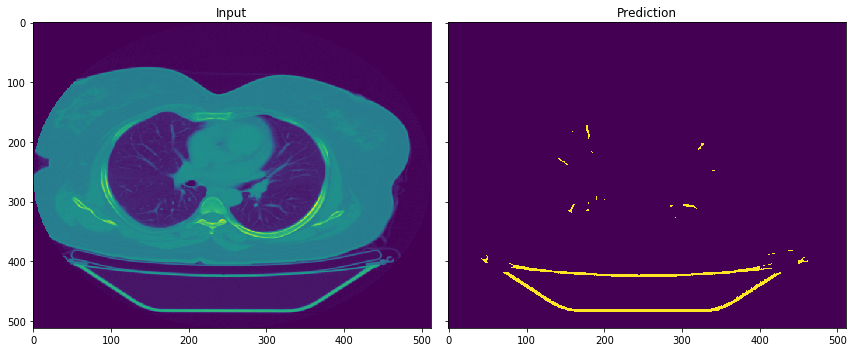

In [41]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,5))
ax[0].imshow(X_test[0,...,0], aspect="auto")
#ax[1].imshow(Y_test[0,...,1], aspect="auto")
mask = np.zeros_like(prediction[0,...,1],dtype="float32")
mask[prediction[0,...,1] > 0.55]=1.0
ax[1].imshow(mask, aspect="auto")
ax[0].set_title("Input")
#ax[1].set_title("Ground truth")
ax[1].set_title("Prediction")
fig.tight_layout()
#fig.savefig("../Image_Seg/prediction_model_50_500_3/output_test_5.png")

In [ ]:
plot_prediction(x_test=X_test,y_test=Y_test,prediction=prediction,save=False)

> Other models which can be tried in future

In [28]:
def create_conv_net_2(x, keep_prob, channels, n_class, layers=7, features_root=16, filter_size=3, pool_size=2, summaries=False):
    """
    Creates a new convolutional unet for the given parametrization.
    
    :param x: input tensor, shape [?,nx,ny,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    :param summaries: Flag if summaries should be created
    """
    
    logging.info("Layers {layers}, features {features}, filter size {filter_size}x{filter_size},pool size: {pool_size}x{pool_size}".format(layers=layers,
                                                                                                           features=features_root,
                                                                                                           filter_size=filter_size,
                                                                                                           pool_size=pool_size))
    # Placeholder for the input image
    nx = tf.shape(x)[1]
    ny = tf.shape(x)[2]
    x_image = tf.reshape(x, tf.stack([-1,nx,ny,channels]))
    in_node = x_image
    batch_size = tf.shape(x_image)[0]
 
    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()
    paddings=[[0,0],[1,1],[1,1],[0,0]]
    in_size = 1000
    size = in_size
    # down layers
    for layer in range(0, layers):
        features = 2**layer*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))
        if layer == 0:
            w1 = weight_variable([filter_size, filter_size, channels, features], stddev)
        else:
            w1 = weight_variable([filter_size, filter_size, features//2, features], stddev)
            
        w2 = weight_variable([filter_size, filter_size, features, features], stddev)
        b1 = bias_variable([features])
        b2 = bias_variable([features])
        
        in_node = tf.pad(in_node,paddings,"CONSTANT")
        conv1 = conv2d(in_node, w1, keep_prob)
        tmp_h_conv = tf.nn.relu(conv1 + b1)
        tmp_h_conv = tf.pad(tmp_h_conv,paddings,"CONSTANT")
        conv2 = conv2d(tmp_h_conv, w2, keep_prob)
        dw_h_convs[layer] = tf.nn.relu(conv2 + b2)
        
        weights.append((w1, w2))
        biases.append((b1, b2))
        convs.append((conv1, conv2))
        
        size -= 4
        if layer < layers-1:
            pools[layer] = max_pool(dw_h_convs[layer], pool_size)
            in_node = pools[layer]
            size /= 2
        
    in_node = dw_h_convs[layers-1]
        
    # up layers
    for layer in range(layers-2, -1, -1):
        
        features = 2**(layer+1)*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))
        
        wd = weight_variable_devonc([pool_size, pool_size, features//2, features], stddev)
        bd = bias_variable([features//2])
        h_deconv = tf.nn.relu(deconv2d(in_node, wd, pool_size) + bd)
        h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)
        deconv[layer] = h_deconv_concat
        
        w1 = weight_variable([filter_size, filter_size, features, features//2], stddev)
        w2 = weight_variable([filter_size, filter_size, features//2, features//2], stddev)
        b1 = bias_variable([features//2])
        b2 = bias_variable([features//2])
        
        h_deconv_concat = tf.pad(h_deconv_concat,paddings,"CONSTANT")
        conv1 = conv2d(h_deconv_concat, w1, keep_prob)
        h_conv = tf.nn.relu(conv1 + b1)
        h_conv = tf.pad(h_conv,paddings,"CONSTANT")
        conv2 = conv2d(h_conv, w2, keep_prob)
        in_node = tf.nn.relu(conv2 + b2)
        up_h_convs[layer] = in_node

        weights.append((w1, w2))
        biases.append((b1, b2))
        convs.append((conv1, conv2))
        
        size *= 2
        size -= 4

    # Output Map
    weight = weight_variable([1, 1, features_root, n_class], stddev)
    bias = bias_variable([n_class])
    conv = conv2d(in_node, weight, tf.constant(1.0))
    output_map = tf.nn.relu(conv + bias)
    up_h_convs["out"] = output_map
    
    if summaries:
        for i, (c1, c2) in enumerate(convs):
            tf.summary.image('summary_conv_%02d_01'%i, get_image_summary(c1))
            tf.summary.image('summary_conv_%02d_02'%i, get_image_summary(c2))
            
        for k in pools.keys():
            tf.summary.image('summary_pool_%02d'%k, get_image_summary(pools[k]))
        
        for k in deconv.keys():
            tf.summary.image('summary_deconv_concat_%02d'%k, get_image_summary(deconv[k]))
            
        for k in dw_h_convs.keys():
            tf.summary.histogram("dw_convolution_%02d"%k + '/activations', dw_h_convs[k])

        for k in up_h_convs.keys():
            tf.summary.histogram("up_convolution_%s"%k + '/activations', up_h_convs[k])
            
    variables = []
    for w1,w2 in weights:
        variables.append(w1)
        variables.append(w2)
        
    for b1,b2 in biases:
        variables.append(b1)
        variables.append(b2)

    
    return output_map, variables, int(in_size - size)

In [76]:
class Unet(object):
    """
    A unet implementation
    
    :param channels: (optional) number of channels in the input image
    :param n_class: (optional) number of output labels
    :param cost: (optional) name of the cost function. Default is 'cross_entropy'
    :param cost_kwargs: (optional) kwargs passed to the cost function. See Unet._get_cost for more options
    """
    
    def __init__(self, channels=1, n_class=2, cost="cross_entropy", cost_kwargs={}, **kwargs):
        tf.reset_default_graph()
        
        self.n_class = n_class
        self.summaries = kwargs.get("summaries", True)
        
        self.x = tf.placeholder("float", shape=[None, None, None, channels])
        self.y = tf.placeholder("float", shape=[None, None, None, n_class])
        self.keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
        
        logits, self.variables, self.offset = create_conv_net_2(self.x, self.keep_prob, channels, n_class, **kwargs)
        
        self.cost = self._get_cost(logits, cost, cost_kwargs)
        
        self.gradients_node = tf.gradients(self.cost, self.variables)
         
        self.cross_entropy = tf.reduce_mean(cross_entropy(tf.reshape(self.y, [-1, n_class]),
                                                          tf.reshape(pixel_wise_softmax_2(logits), [-1, n_class])))
        
        self.predicter = pixel_wise_softmax_2(logits)
        self.correct_pred = tf.equal(tf.argmax(self.predicter, 3), tf.argmax(self.y, 3))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        
    def _get_cost(self, logits, cost_name, cost_kwargs):
        """
        Constructs the cost function, either cross_entropy, weighted cross_entropy or dice_coefficient.
        Optional arguments are: 
        class_weights: weights for the different classes in case of multi-class imbalance
        regularizer: power of the L2 regularizers added to the loss function
        """
        
        flat_logits = tf.reshape(logits, [-1, self.n_class])
        flat_labels = tf.reshape(self.y, [-1, self.n_class])
        if cost_name == "cross_entropy":
            class_weights = cost_kwargs.pop("class_weights", None)
            
            if class_weights is not None:
                class_weights = tf.constant(np.array(class_weights, dtype=np.float32))
        
                weight_map = tf.multiply(flat_labels, class_weights)
                weight_map = tf.reduce_sum(weight_map, axis=1)
        
                loss_map = tf.nn.softmax_cross_entropy_with_logits(flat_logits, flat_labels)
                weighted_loss = tf.multiply(loss_map, weight_map)
        
                loss = tf.reduce_mean(weighted_loss)
                
            else:
                loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, 
                                                                              labels=flat_labels))
        elif cost_name == "dice_coefficient":
            eps = 1e-5
            prediction = pixel_wise_softmax_2(logits)
            intersection = tf.reduce_sum(prediction * self.y)
            union =  eps + tf.reduce_sum(prediction) + tf.reduce_sum(self.y)
            loss = -(2 * intersection/ (union))
            
        else:
            raise ValueError("Unknown cost function: "%cost_name)

        regularizer = cost_kwargs.pop("regularizer", None)
        if regularizer is not None:
            regularizers = sum([tf.nn.l2_loss(variable) for variable in self.variables])
            loss += (regularizer * regularizers)
            
        return loss

    def predict(self, model_path, x_test):
        """
        Uses the model to create a prediction for the given data
        
        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, channels]
        :returns prediction: The unet prediction Shape [n, px, py, labels] (px=nx-self.offset/2) 
        """
        
        init = tf.global_variables_initializer()
        with tf.Session(config=config) as sess:
            # Initialize variables
            sess.run(init)
        
            # Restore model weights from previously saved model
            self.restore(sess, model_path)
            
            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], self.n_class))
            prediction = sess.run(self.predicter, feed_dict={self.x: x_test, self.y: y_dummy, self.keep_prob: 1.})
            
        return prediction
    
    def save(self, sess, model_path):
        """
        Saves the current session to a checkpoint
        
        :param sess: current session
        :param model_path: path to file system location
        """
        
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path
    
    def restore(self, sess, model_path):
        """
        Restores a session from a checkpoint
        
        :param sess: current session instance
        :param model_path: path to file system checkpoint location
        """
        
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        logging.info("Model restored from file: %s" % model_path)

In [30]:
class Trainer(object):
    """
    Trains a unet instance
    
    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param optimizer: (optional) name of the optimizer to use (momentum or adam)
    :param opt_kwargs: (optional) kwargs passed to the learning rate (momentum opt) and to the optimizer
    """
    
    prediction_path = "prediction_model2"    ### to channge this before running......give number at the end.
    verification_batch_size = 4
    
    def __init__(self, net, batch_size=1, optimizer="momentum", opt_kwargs={}):
        self.net = net
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs
        
    def _get_optimizer(self, training_iters, global_step):
        if self.optimizer == "momentum":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.2)
            decay_rate = self.opt_kwargs.pop("decay_rate", 0.95)
            momentum = self.opt_kwargs.pop("momentum", 0.2)
            
            self.learning_rate_node = tf.train.exponential_decay(learning_rate=learning_rate, 
                                                        global_step=global_step, 
                                                        decay_steps=training_iters,  
                                                        decay_rate=decay_rate, 
                                                        staircase=True)
            
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate_node, momentum=momentum,
                                                   **self.opt_kwargs).minimize(self.net.cost, 
                                                                                global_step=global_step)
        elif self.optimizer == "adam":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.001)
            self.learning_rate_node = tf.Variable(learning_rate)
            
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_node, 
                                               **self.opt_kwargs).minimize(self.net.cost,
                                                                     global_step=global_step)
        
        return optimizer
        
    def _initialize(self, training_iters, output_path, restore):
        global_step = tf.Variable(0)
        
        self.norm_gradients_node = tf.Variable(tf.constant(0.0, shape=[len(self.net.gradients_node)]))
        
        if self.net.summaries:
            tf.summary.histogram('norm_grads', self.norm_gradients_node)

        tf.summary.scalar('loss', self.net.cost)
        tf.summary.scalar('cross_entropy', self.net.cross_entropy)
        tf.summary.scalar('accuracy', self.net.accuracy)

        self.optimizer = self._get_optimizer(training_iters, global_step)
        tf.summary.scalar('learning_rate', self.learning_rate_node)

        self.summary_op = tf.summary.merge_all()        
        init = tf.global_variables_initializer()
        
        prediction_path = os.path.abspath(self.prediction_path)
        output_path = os.path.abspath(output_path)
        
        if not restore:
            logging.info("Removing '{:}'".format(prediction_path))
            shutil.rmtree(prediction_path, ignore_errors=True)
            logging.info("Removing '{:}'".format(output_path))
            shutil.rmtree(output_path, ignore_errors=True)
        
        if not os.path.exists(prediction_path):
            logging.info("Allocating '{:}'".format(prediction_path))
            os.makedirs(prediction_path)
        
        if not os.path.exists(output_path):
            logging.info("Allocating '{:}'".format(output_path))
            os.makedirs(output_path)
        
        return init

    def train(self, data_provider, output_path, training_iters=10, epochs=100, dropout=0.75, display_step=1, restore=False, write_graph=False):
        """
        Lauches the training process
        
        :param data_provider: callable returning training and verification data
        :param output_path: path where to store checkpoints
        :param training_iters: number of training mini batch iteration
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored 
        :param write_graph: Flag if the computation graph should be written as protobuf file to the output path
        """
        save_path = os.path.join(output_path, "model_2.cpkt")  ## ////..change the save path before running if you want to be in same path..////
        if epochs == 0:
            return save_path
        
        init = self._initialize(training_iters, output_path, restore)
        
        with tf.Session(config=config) as sess:
            if write_graph:
                tf.train.write_graph(sess.graph_def, output_path, "graph.pb", False)
            
            sess.run(init)
            
            if restore:
                ckpt = tf.train.get_checkpoint_state(output_path)
                if ckpt and ckpt.model_checkpoint_path:
                    self.net.restore(sess, ckpt.model_checkpoint_path)
            
            test_x, test_y = data_provider(self.verification_batch_size)
            pred_shape = self.store_prediction(sess, test_x, test_y, "_init")
            nuksaan =[]
            
            summary_writer = tf.summary.FileWriter(output_path, graph=sess.graph)
            logging.info("Start optimization")
            
            avg_gradients = None
            for epoch in range(epochs):
                total_loss = 0
                for step in range((epoch*training_iters), ((epoch+1)*training_iters)):
                    batch_x, batch_y = data_provider(self.batch_size)
                     
                    # Run optimization op (backprop)
                    _, loss, lr, gradients = sess.run((self.optimizer, self.net.cost, self.learning_rate_node, self.net.gradients_node), 
                                                      feed_dict={self.net.x: batch_x,
                                                                 self.net.y: crop_to_shape(batch_y, pred_shape),
                                                                 self.net.keep_prob: dropout})

                    if avg_gradients is None:
                        avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
                    for i in range(len(gradients)):
                        avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step+1)))) + (gradients[i] / (step+1))
                        
                    norm_gradients = [np.linalg.norm(gradient) for gradient in avg_gradients]
                    self.norm_gradients_node.assign(norm_gradients).eval()
                    
                    if step % display_step == 0:
                        self.output_minibatch_stats(sess, summary_writer, step, batch_x, crop_to_shape(batch_y, pred_shape))
                        
                    total_loss += loss
                    nuksaan.append(total_loss)

                self.output_epoch_stats(epoch, total_loss, training_iters, lr)
                self.store_prediction(sess, test_x, test_y, "epoch_%s"%epoch)
                    
                save_path = self.net.save(sess, save_path)
            logging.info("Optimization Finished!")
            
            return save_path, nuksaan
        
    def store_prediction(self, sess, batch_x, batch_y, name):
        prediction = sess.run(self.net.predicter, feed_dict={self.net.x: batch_x,self.net.y: batch_y,self.net.keep_prob:1.})
        pred_shape = prediction.shape
        
        loss = sess.run(self.net.cost, feed_dict={self.net.x: batch_x, 
                                                       self.net.y: crop_to_shape(batch_y, pred_shape), 
                                                       self.net.keep_prob: 1.})
        
        logging.info("Verification error= {:.1f}%, loss= {:.4f}".format(error_rate(prediction,
                                                                          crop_to_shape(batch_y,
                                                                                             prediction.shape)),
                                                                          loss))
              
        img = combine_img_prediction(batch_x, batch_y, prediction)
        save_image(img, "%s/%s.jpg"%(self.prediction_path, name))
        
        return pred_shape
    
    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info("Epoch {:}, Average loss: {:.4f}, learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))
    
    def output_minibatch_stats(self, sess, summary_writer, step, batch_x, batch_y):
        # Calculate batch loss and accuracy
        summary_str, loss, acc, predictions = sess.run([self.summary_op, 
                                                            self.net.cost, 
                                                            self.net.accuracy, 
                                                            self.net.predicter], 
                                                           feed_dict={self.net.x: batch_x,
                                                                      self.net.y: batch_y,
                                                                      self.net.keep_prob: 1.})
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()
        logging.info("Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch error= {:.1f}%".format(step,
                                                                                                            loss,
                                                                                                            acc,
                                                                                                            error_rate(predictions, batch_y)))

In [43]:
net = Unet(channels=mydata_test.channels, n_class=mydata_test.n_class, layers=7, features_root=16)

2017-07-26 11:35:07,017 Layers 7, features 16, filter size 3x3,pool size: 2x2


In [36]:
trainer = Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))

In [37]:
output_path = "./unet_trained_2"

In [38]:
path, nuksaan2 = trainer.train(mydata, output_path=output_path, training_iters=50, epochs=150, display_step=10)

2017-07-17 18:02:51,825 Removing '/home/ctuser/Desktop/Image_Seg/prediction_model2'
2017-07-17 18:02:51,827 Removing '/home/ctuser/Desktop/Image_Seg/unet_trained_2'
2017-07-17 18:02:51,859 Allocating '/home/ctuser/Desktop/Image_Seg/prediction_model2'
2017-07-17 18:02:51,860 Allocating '/home/ctuser/Desktop/Image_Seg/unet_trained_2'
2017-07-17 18:02:52,994 Verification error= 60.9%, loss= 0.6948
2017-07-17 18:02:54,246 Start optimization
2017-07-17 18:02:55,135 Iter 0, Minibatch Loss= 0.5051, Training Accuracy= 0.9759, Minibatch error= 2.4%
2017-07-17 18:03:00,470 Iter 10, Minibatch Loss= 0.1054, Training Accuracy= 0.9781, Minibatch error= 2.2%
2017-07-17 18:03:05,825 Iter 20, Minibatch Loss= 0.1117, Training Accuracy= 0.9755, Minibatch error= 2.5%
2017-07-17 18:03:11,070 Iter 30, Minibatch Loss= 0.0275, Training Accuracy= 0.9961, Minibatch error= 0.4%
2017-07-17 18:03:16,378 Iter 40, Minibatch Loss= 0.0430, Training Accuracy= 0.9919, Minibatch error= 0.8%
2017-07-17 18:03:21,180 Epoch 

2017-07-17 18:10:11,319 Iter 590, Minibatch Loss= 0.0122, Training Accuracy= 0.9869, Minibatch error= 1.3%
2017-07-17 18:10:17,432 Epoch 11, Average loss: 0.0197, learning rate: 0.1138
2017-07-17 18:10:17,761 Verification error= 1.0%, loss= 0.0133
2017-07-17 18:10:24,495 Iter 600, Minibatch Loss= 0.0164, Training Accuracy= 0.9867, Minibatch error= 1.3%
2017-07-17 18:10:32,111 Iter 610, Minibatch Loss= 0.0144, Training Accuracy= 0.9956, Minibatch error= 0.4%
2017-07-17 18:10:39,340 Iter 620, Minibatch Loss= 0.0193, Training Accuracy= 0.9942, Minibatch error= 0.6%
2017-07-17 18:10:46,540 Iter 630, Minibatch Loss= 0.0292, Training Accuracy= 0.9932, Minibatch error= 0.7%
2017-07-17 18:10:54,155 Iter 640, Minibatch Loss= 0.0166, Training Accuracy= 0.9969, Minibatch error= 0.3%
2017-07-17 18:11:00,670 Epoch 12, Average loss: 0.0183, learning rate: 0.1081
2017-07-17 18:11:00,999 Verification error= 0.3%, loss= 0.0137
2017-07-17 18:11:07,302 Iter 650, Minibatch Loss= 0.0198, Training Accuracy=

2017-07-17 18:20:14,583 Epoch 23, Average loss: 0.0098, learning rate: 0.0615
2017-07-17 18:20:14,906 Verification error= 0.2%, loss= 0.0075
2017-07-17 18:20:21,662 Iter 1200, Minibatch Loss= 0.0100, Training Accuracy= 0.9966, Minibatch error= 0.3%
2017-07-17 18:20:31,466 Iter 1210, Minibatch Loss= 0.0097, Training Accuracy= 0.9985, Minibatch error= 0.2%
2017-07-17 18:20:40,840 Iter 1220, Minibatch Loss= 0.0087, Training Accuracy= 0.9980, Minibatch error= 0.2%
2017-07-17 18:20:50,342 Iter 1230, Minibatch Loss= 0.0061, Training Accuracy= 0.9977, Minibatch error= 0.2%
2017-07-17 18:20:59,560 Iter 1240, Minibatch Loss= 0.0076, Training Accuracy= 0.9980, Minibatch error= 0.2%
2017-07-17 18:21:07,955 Epoch 24, Average loss: 0.0097, learning rate: 0.0584
2017-07-17 18:21:08,300 Verification error= 0.2%, loss= 0.0066
2017-07-17 18:21:15,022 Iter 1250, Minibatch Loss= 0.0076, Training Accuracy= 0.9976, Minibatch error= 0.2%
2017-07-17 18:21:24,971 Iter 1260, Minibatch Loss= 0.0059, Training Ac

2017-07-17 18:32:07,225 Verification error= 0.2%, loss= 0.0060
2017-07-17 18:32:15,247 Iter 1800, Minibatch Loss= 0.0105, Training Accuracy= 0.9963, Minibatch error= 0.4%
2017-07-17 18:32:26,333 Iter 1810, Minibatch Loss= 0.0055, Training Accuracy= 0.9988, Minibatch error= 0.1%
2017-07-17 18:32:37,409 Iter 1820, Minibatch Loss= 0.0085, Training Accuracy= 0.9964, Minibatch error= 0.4%
2017-07-17 18:32:48,880 Iter 1830, Minibatch Loss= 0.0092, Training Accuracy= 0.9959, Minibatch error= 0.4%
2017-07-17 18:32:59,908 Iter 1840, Minibatch Loss= 0.0050, Training Accuracy= 0.9980, Minibatch error= 0.2%
2017-07-17 18:33:09,936 Epoch 36, Average loss: 0.0077, learning rate: 0.0316
2017-07-17 18:33:10,259 Verification error= 0.2%, loss= 0.0058
2017-07-17 18:33:18,271 Iter 1850, Minibatch Loss= 0.0098, Training Accuracy= 0.9967, Minibatch error= 0.3%
2017-07-17 18:33:29,564 Iter 1860, Minibatch Loss= 0.0104, Training Accuracy= 0.9956, Minibatch error= 0.4%
2017-07-17 18:33:41,049 Iter 1870, Minib

2017-07-17 18:45:55,516 Iter 2400, Minibatch Loss= 0.0098, Training Accuracy= 0.9957, Minibatch error= 0.4%
2017-07-17 18:46:08,993 Iter 2410, Minibatch Loss= 0.0032, Training Accuracy= 0.9991, Minibatch error= 0.1%
2017-07-17 18:46:21,740 Iter 2420, Minibatch Loss= 0.0444, Training Accuracy= 0.9799, Minibatch error= 2.0%
2017-07-17 18:46:34,737 Iter 2430, Minibatch Loss= 0.0112, Training Accuracy= 0.9947, Minibatch error= 0.5%
2017-07-17 18:46:47,650 Iter 2440, Minibatch Loss= 0.0067, Training Accuracy= 0.9974, Minibatch error= 0.3%
2017-07-17 18:46:59,257 Epoch 48, Average loss: 0.0084, learning rate: 0.0171
2017-07-17 18:46:59,578 Verification error= 0.2%, loss= 0.0053
2017-07-17 18:47:07,942 Iter 2450, Minibatch Loss= 0.0058, Training Accuracy= 0.9988, Minibatch error= 0.1%
2017-07-17 18:47:21,440 Iter 2460, Minibatch Loss= 0.0053, Training Accuracy= 0.9979, Minibatch error= 0.2%
2017-07-17 18:47:34,893 Iter 2470, Minibatch Loss= 0.0111, Training Accuracy= 0.9953, Minibatch error= 

2017-07-17 19:02:03,529 Iter 3010, Minibatch Loss= 0.0058, Training Accuracy= 0.9973, Minibatch error= 0.3%
2017-07-17 19:02:19,193 Iter 3020, Minibatch Loss= 0.0023, Training Accuracy= 0.9994, Minibatch error= 0.1%
2017-07-17 19:02:34,229 Iter 3030, Minibatch Loss= 0.0100, Training Accuracy= 0.9952, Minibatch error= 0.5%
2017-07-17 19:02:50,007 Iter 3040, Minibatch Loss= 0.0132, Training Accuracy= 0.9936, Minibatch error= 0.6%
2017-07-17 19:03:03,525 Epoch 60, Average loss: 0.0093, learning rate: 0.0092
2017-07-17 19:03:03,842 Verification error= 0.2%, loss= 0.0056
2017-07-17 19:03:13,080 Iter 3050, Minibatch Loss= 0.0031, Training Accuracy= 0.9993, Minibatch error= 0.1%
2017-07-17 19:03:28,314 Iter 3060, Minibatch Loss= 0.0035, Training Accuracy= 0.9985, Minibatch error= 0.1%
2017-07-17 19:03:43,551 Iter 3070, Minibatch Loss= 0.0425, Training Accuracy= 0.9815, Minibatch error= 1.9%
2017-07-17 19:03:59,361 Iter 3080, Minibatch Loss= 0.0069, Training Accuracy= 0.9970, Minibatch error= 

2017-07-17 19:20:27,704 Iter 3620, Minibatch Loss= 0.0031, Training Accuracy= 0.9990, Minibatch error= 0.1%
2017-07-17 19:20:45,909 Iter 3630, Minibatch Loss= 0.0117, Training Accuracy= 0.9944, Minibatch error= 0.6%
2017-07-17 19:21:05,270 Iter 3640, Minibatch Loss= 0.0053, Training Accuracy= 0.9982, Minibatch error= 0.2%
2017-07-17 19:21:23,086 Epoch 72, Average loss: 0.0081, learning rate: 0.0050
2017-07-17 19:21:23,403 Verification error= 0.2%, loss= 0.0054
2017-07-17 19:21:40,587 Iter 3650, Minibatch Loss= 0.0035, Training Accuracy= 0.9993, Minibatch error= 0.1%
2017-07-17 19:21:57,812 Iter 3660, Minibatch Loss= 0.0099, Training Accuracy= 0.9957, Minibatch error= 0.4%
2017-07-17 19:22:14,792 Iter 3670, Minibatch Loss= 0.0050, Training Accuracy= 0.9983, Minibatch error= 0.2%
2017-07-17 19:22:31,786 Iter 3680, Minibatch Loss= 0.0029, Training Accuracy= 0.9991, Minibatch error= 0.1%
2017-07-17 19:22:48,990 Iter 3690, Minibatch Loss= 0.0116, Training Accuracy= 0.9955, Minibatch error= 

2017-07-17 19:41:50,106 Iter 4230, Minibatch Loss= 0.0026, Training Accuracy= 0.9993, Minibatch error= 0.1%
2017-07-17 19:42:09,484 Iter 4240, Minibatch Loss= 0.0024, Training Accuracy= 0.9995, Minibatch error= 0.1%
2017-07-17 19:42:26,943 Epoch 84, Average loss: 0.0066, learning rate: 0.0027
2017-07-17 19:42:27,262 Verification error= 0.2%, loss= 0.0054
2017-07-17 19:42:40,576 Iter 4250, Minibatch Loss= 0.0026, Training Accuracy= 0.9994, Minibatch error= 0.1%
2017-07-17 19:43:01,156 Iter 4260, Minibatch Loss= 0.0125, Training Accuracy= 0.9953, Minibatch error= 0.5%
2017-07-17 19:43:20,975 Iter 4270, Minibatch Loss= 0.0111, Training Accuracy= 0.9953, Minibatch error= 0.5%
2017-07-17 19:43:40,428 Iter 4280, Minibatch Loss= 0.0010, Training Accuracy= 0.9998, Minibatch error= 0.0%
2017-07-17 19:43:59,874 Iter 4290, Minibatch Loss= 0.0041, Training Accuracy= 0.9984, Minibatch error= 0.2%
2017-07-17 19:44:17,270 Epoch 85, Average loss: 0.0079, learning rate: 0.0026
2017-07-17 19:44:17,591 V

2017-07-17 20:06:00,856 Iter 4840, Minibatch Loss= 0.0044, Training Accuracy= 0.9990, Minibatch error= 0.1%
2017-07-17 20:06:20,211 Epoch 96, Average loss: 0.0070, learning rate: 0.0015
2017-07-17 20:06:20,532 Verification error= 0.2%, loss= 0.0053
2017-07-17 20:06:35,242 Iter 4850, Minibatch Loss= 0.0043, Training Accuracy= 0.9982, Minibatch error= 0.2%
2017-07-17 20:06:56,333 Iter 4860, Minibatch Loss= 0.0134, Training Accuracy= 0.9946, Minibatch error= 0.5%
2017-07-17 20:07:18,120 Iter 4870, Minibatch Loss= 0.0123, Training Accuracy= 0.9951, Minibatch error= 0.5%
2017-07-17 20:07:39,527 Iter 4880, Minibatch Loss= 0.0100, Training Accuracy= 0.9958, Minibatch error= 0.4%
2017-07-17 20:08:01,678 Iter 4890, Minibatch Loss= 0.0028, Training Accuracy= 0.9991, Minibatch error= 0.1%
2017-07-17 20:08:21,915 Epoch 97, Average loss: 0.0088, learning rate: 0.0014
2017-07-17 20:08:22,238 Verification error= 0.2%, loss= 0.0054
2017-07-17 20:08:39,349 Iter 4900, Minibatch Loss= 0.0067, Training Ac

2017-07-17 20:34:03,900 Epoch 108, Average loss: 0.0068, learning rate: 0.0008
2017-07-17 20:34:04,237 Verification error= 0.2%, loss= 0.0054
2017-07-17 20:34:26,817 Iter 5450, Minibatch Loss= 0.0073, Training Accuracy= 0.9976, Minibatch error= 0.2%
2017-07-17 20:34:50,931 Iter 5460, Minibatch Loss= 0.0064, Training Accuracy= 0.9981, Minibatch error= 0.2%
2017-07-17 20:35:16,032 Iter 5470, Minibatch Loss= 0.0076, Training Accuracy= 0.9968, Minibatch error= 0.3%
2017-07-17 20:35:39,496 Iter 5480, Minibatch Loss= 0.0029, Training Accuracy= 0.9990, Minibatch error= 0.1%
2017-07-17 20:36:03,109 Iter 5490, Minibatch Loss= 0.0030, Training Accuracy= 0.9991, Minibatch error= 0.1%
2017-07-17 20:36:24,248 Epoch 109, Average loss: 0.0088, learning rate: 0.0007
2017-07-17 20:36:24,566 Verification error= 0.2%, loss= 0.0054
2017-07-17 20:36:43,709 Iter 5500, Minibatch Loss= 0.0043, Training Accuracy= 0.9981, Minibatch error= 0.2%
2017-07-17 20:37:08,149 Iter 5510, Minibatch Loss= 0.0056, Training 

2017-07-17 21:03:05,414 Verification error= 0.2%, loss= 0.0054
2017-07-17 21:03:29,241 Iter 6050, Minibatch Loss= 0.0036, Training Accuracy= 0.9994, Minibatch error= 0.1%
2017-07-17 21:03:55,818 Iter 6060, Minibatch Loss= 0.0075, Training Accuracy= 0.9972, Minibatch error= 0.3%
2017-07-17 21:04:22,395 Iter 6070, Minibatch Loss= 0.0048, Training Accuracy= 0.9985, Minibatch error= 0.2%
2017-07-17 21:04:48,090 Iter 6080, Minibatch Loss= 0.0028, Training Accuracy= 0.9993, Minibatch error= 0.1%
2017-07-17 21:05:15,080 Iter 6090, Minibatch Loss= 0.0049, Training Accuracy= 0.9984, Minibatch error= 0.2%
2017-07-17 21:05:38,546 Epoch 121, Average loss: 0.0078, learning rate: 0.0004
2017-07-17 21:05:38,868 Verification error= 0.2%, loss= 0.0053
2017-07-17 21:05:59,639 Iter 6100, Minibatch Loss= 0.0039, Training Accuracy= 0.9986, Minibatch error= 0.1%
2017-07-17 21:06:26,229 Iter 6110, Minibatch Loss= 0.0070, Training Accuracy= 0.9970, Minibatch error= 0.3%
2017-07-17 21:06:54,859 Iter 6120, Mini

2017-07-17 21:36:08,730 Iter 6650, Minibatch Loss= 0.0028, Training Accuracy= 0.9992, Minibatch error= 0.1%
2017-07-17 21:36:37,335 Iter 6660, Minibatch Loss= 0.0035, Training Accuracy= 0.9988, Minibatch error= 0.1%
2017-07-17 21:37:06,966 Iter 6670, Minibatch Loss= 0.0057, Training Accuracy= 0.9974, Minibatch error= 0.3%
2017-07-17 21:37:36,199 Iter 6680, Minibatch Loss= 0.0097, Training Accuracy= 0.9955, Minibatch error= 0.5%
2017-07-17 21:38:05,969 Iter 6690, Minibatch Loss= 0.0050, Training Accuracy= 0.9978, Minibatch error= 0.2%
2017-07-17 21:38:31,549 Epoch 133, Average loss: 0.0065, learning rate: 0.0002
2017-07-17 21:38:31,870 Verification error= 0.2%, loss= 0.0053
2017-07-17 21:38:55,028 Iter 6700, Minibatch Loss= 0.0023, Training Accuracy= 0.9995, Minibatch error= 0.1%
2017-07-17 21:39:23,085 Iter 6710, Minibatch Loss= 0.0062, Training Accuracy= 0.9974, Minibatch error= 0.3%
2017-07-17 21:39:53,058 Iter 6720, Minibatch Loss= 0.0029, Training Accuracy= 0.9991, Minibatch error=

2017-07-17 22:11:09,933 Iter 7260, Minibatch Loss= 0.0429, Training Accuracy= 0.9814, Minibatch error= 1.9%
2017-07-17 22:11:40,973 Iter 7270, Minibatch Loss= 0.0070, Training Accuracy= 0.9969, Minibatch error= 0.3%
2017-07-17 22:12:12,303 Iter 7280, Minibatch Loss= 0.0051, Training Accuracy= 0.9983, Minibatch error= 0.2%
2017-07-17 22:12:43,421 Iter 7290, Minibatch Loss= 0.0161, Training Accuracy= 0.9928, Minibatch error= 0.7%
2017-07-17 22:13:11,974 Epoch 145, Average loss: 0.0078, learning rate: 0.0001
2017-07-17 22:13:12,291 Verification error= 0.2%, loss= 0.0053
2017-07-17 22:13:34,089 Iter 7300, Minibatch Loss= 0.0038, Training Accuracy= 0.9989, Minibatch error= 0.1%
2017-07-17 22:14:05,968 Iter 7310, Minibatch Loss= 0.0047, Training Accuracy= 0.9985, Minibatch error= 0.2%
2017-07-17 22:14:36,338 Iter 7320, Minibatch Loss= 0.0027, Training Accuracy= 0.9993, Minibatch error= 0.1%
2017-07-17 22:15:08,089 Iter 7330, Minibatch Loss= 0.0030, Training Accuracy= 0.9991, Minibatch error=

In [ ]:
prediction = net.predict("./unet_trained_2/model_2.cpkt", X_test)

In [79]:
err2 = error_rate(prediction,Y_test)
errors.append(err2)

In [80]:
err2

0.2738189697265625

In [81]:
errors

[0.20687103271484375, 0.2738189697265625]

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


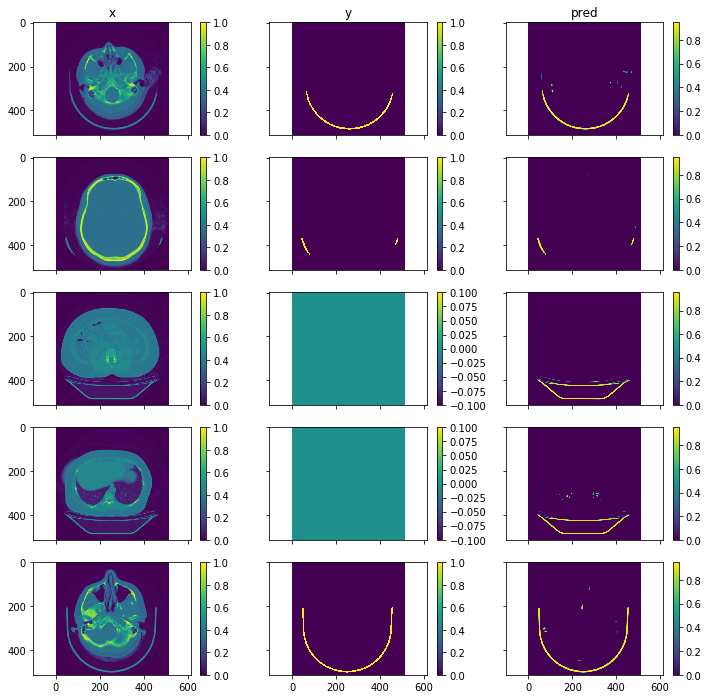

In [45]:
plot_prediction(x_test=X_test,y_test=Y_test,prediction=prediction,save=False)

______

In [ ]:
def create_conv_net_1(x, keep_prob, channels, n_class, layers=5, features_root=16, filter_size=3, pool_size=2, summaries=False):
    """
    Creates a new convolutional unet for the given parametrization.
    
    :param x: input tensor, shape [?,nx,ny,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    :param summaries: Flag if summaries should be created
    """
    
    logging.info("Layers {layers}, features {features}, filter size {filter_size}x{filter_size},pool size: {pool_size}x{pool_size}".format(layers=layers,
                                                                                                           features=features_root,
                                                                                                           filter_size=filter_size,
                                                                                                           pool_size=pool_size))
    # Placeholder for the input image
    nx = tf.shape(x)[1]
    ny = tf.shape(x)[2]
    x_image = tf.reshape(x, tf.stack([-1,nx,ny,channels]))
    in_node = x_image
    batch_size = tf.shape(x_image)[0]
 
    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()
    paddings=[[0,0],[1,1],[1,1],[0,0]]
    in_size = 1000
    size = in_size
    # down layers
    for layer in range(0, layers):
        features = 2**layer*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))
        if layer == 0:
            w1 = weight_variable([filter_size, filter_size, channels, features], stddev)
        else:
            w1 = weight_variable([filter_size, filter_size, features//2, features], stddev)
            
        w2 = weight_variable([filter_size, filter_size, features, features], stddev)
        b1 = bias_variable([features])
        b2 = bias_variable([features])
        
        in_node = tf.pad(in_node,paddings,"CONSTANT")
        conv1 = conv2d(in_node, w1, keep_prob)
        tmp_h_conv = tf.nn.relu(conv1 + b1)
        tmp_h_conv = tf.pad(tmp_h_conv,paddings,"CONSTANT")
        conv2 = conv2d(tmp_h_conv, w2, keep_prob)
        dw_h_convs[layer] = tf.nn.relu(conv2 + b2)
        
        weights.append((w1, w2))
        biases.append((b1, b2))
        convs.append((conv1, conv2))
        
        size -= 4
        if layer < layers-1:
            pools[layer] = max_pool(dw_h_convs[layer], pool_size)
            in_node = pools[layer]
            size /= 2
        
    in_node = dw_h_convs[layers-1]
        
    # up layers
    for layer in range(layers-2, -1, -1):
        
        features = 2**(layer+1)*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))
        
        wd = weight_variable_devonc([pool_size, pool_size, features//2, features], stddev)
        bd = bias_variable([features//2])
        h_deconv = tf.nn.relu(deconv2d(in_node, wd, pool_size) + bd)
        h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)
        deconv[layer] = h_deconv_concat
        
        w1 = weight_variable([filter_size, filter_size, features, features//2], stddev)
        w2 = weight_variable([filter_size, filter_size, features//2, features//2], stddev)
        b1 = bias_variable([features//2])
        b2 = bias_variable([features//2])
        
        h_deconv_concat = tf.pad(h_deconv_concat,paddings,"CONSTANT")
        conv1 = conv2d(h_deconv_concat, w1, keep_prob)
        h_conv = tf.nn.relu(conv1 + b1)
        h_conv = tf.pad(h_conv,paddings,"CONSTANT")
        conv2 = conv2d(h_conv, w2, keep_prob)
        in_node = tf.nn.relu(conv2 + b2)
        up_h_convs[layer] = in_node

        weights.append((w1, w2))
        biases.append((b1, b2))
        convs.append((conv1, conv2))
        
        size *= 2
        size -= 4

    # Output Map
    weight = weight_variable([1, 1, features_root, n_class], stddev)
    bias = bias_variable([n_class])
    conv = conv2d(in_node, weight, tf.constant(1.0))
    output_map = tf.nn.relu(conv + bias)
    up_h_convs["out"] = output_map
    
    if summaries:
        for i, (c1, c2) in enumerate(convs):
            tf.summary.image('summary_conv_%02d_01'%i, get_image_summary(c1))
            tf.summary.image('summary_conv_%02d_02'%i, get_image_summary(c2))
            
        for k in pools.keys():
            tf.summary.image('summary_pool_%02d'%k, get_image_summary(pools[k]))
        
        for k in deconv.keys():
            tf.summary.image('summary_deconv_concat_%02d'%k, get_image_summary(deconv[k]))
            
        for k in dw_h_convs.keys():
            tf.summary.histogram("dw_convolution_%02d"%k + '/activations', dw_h_convs[k])

        for k in up_h_convs.keys():
            tf.summary.histogram("up_convolution_%s"%k + '/activations', up_h_convs[k])
            
    variables = []
    for w1,w2 in weights:
        variables.append(w1)
        variables.append(w2)
        
    for b1,b2 in biases:
        variables.append(b1)
        variables.append(b2)

    
    return output_map, variables, int(in_size - size)

In [ ]:
class Unet(object):
    """
    A unet implementation
    
    :param channels: (optional) number of channels in the input image
    :param n_class: (optional) number of output labels
    :param cost: (optional) name of the cost function. Default is 'cross_entropy'
    :param cost_kwargs: (optional) kwargs passed to the cost function. See Unet._get_cost for more options
    """
    
    def __init__(self, channels=1, n_class=2, cost="cross_entropy", cost_kwargs={}, **kwargs):
        tf.reset_default_graph()
        
        self.n_class = n_class
        self.summaries = kwargs.get("summaries", True)
        
        self.x = tf.placeholder("float", shape=[None, None, None, channels])
        self.y = tf.placeholder("float", shape=[None, None, None, n_class])
        self.keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
        
        logits, self.variables, self.offset = create_conv_net_1(self.x, self.keep_prob, channels, n_class, **kwargs)
        
        self.cost = self._get_cost(logits, cost, cost_kwargs)
        
        self.gradients_node = tf.gradients(self.cost, self.variables)
         
        self.cross_entropy = tf.reduce_mean(cross_entropy(tf.reshape(self.y, [-1, n_class]),
                                                          tf.reshape(pixel_wise_softmax_2(logits), [-1, n_class])))
        
        self.predicter = pixel_wise_softmax_2(logits)
        self.correct_pred = tf.equal(tf.argmax(self.predicter, 3), tf.argmax(self.y, 3))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        
    def _get_cost(self, logits, cost_name, cost_kwargs):
        """
        Constructs the cost function, either cross_entropy, weighted cross_entropy or dice_coefficient.
        Optional arguments are: 
        class_weights: weights for the different classes in case of multi-class imbalance
        regularizer: power of the L2 regularizers added to the loss function
        """
        
        flat_logits = tf.reshape(logits, [-1, self.n_class])
        flat_labels = tf.reshape(self.y, [-1, self.n_class])
        if cost_name == "cross_entropy":
            class_weights = cost_kwargs.pop("class_weights", None)
            
            if class_weights is not None:
                class_weights = tf.constant(np.array(class_weights, dtype=np.float32))
        
                weight_map = tf.multiply(flat_labels, class_weights)
                weight_map = tf.reduce_sum(weight_map, axis=1)
        
                loss_map = tf.nn.softmax_cross_entropy_with_logits(flat_logits, flat_labels)
                weighted_loss = tf.multiply(loss_map, weight_map)
        
                loss = tf.reduce_mean(weighted_loss)
                
            else:
                loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, 
                                                                              labels=flat_labels))
        elif cost_name == "dice_coefficient":
            eps = 1e-5
            prediction = pixel_wise_softmax_2(logits)
            intersection = tf.reduce_sum(prediction * self.y)
            union =  eps + tf.reduce_sum(prediction) + tf.reduce_sum(self.y)
            loss = -(2 * intersection/ (union))
            
        else:
            raise ValueError("Unknown cost function: "%cost_name)

        regularizer = cost_kwargs.pop("regularizer", None)
        if regularizer is not None:
            regularizers = sum([tf.nn.l2_loss(variable) for variable in self.variables])
            loss += (regularizer * regularizers)
            
        return loss

    def predict(self, model_path, x_test):
        """
        Uses the model to create a prediction for the given data
        
        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, channels]
        :returns prediction: The unet prediction Shape [n, px, py, labels] (px=nx-self.offset/2) 
        """
        
        init = tf.global_variables_initializer()
        with tf.Session(config=config) as sess:
            # Initialize variables
            sess.run(init)
        
            # Restore model weights from previously saved model
            self.restore(sess, model_path)
            
            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], self.n_class))
            prediction = sess.run(self.predicter, feed_dict={self.x: x_test, self.y: y_dummy, self.keep_prob: 1.})
            
        return prediction
    
    def save(self, sess, model_path):
        """
        Saves the current session to a checkpoint
        
        :param sess: current session
        :param model_path: path to file system location
        """
        
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path
    
    def restore(self, sess, model_path):
        """
        Restores a session from a checkpoint
        
        :param sess: current session instance
        :param model_path: path to file system checkpoint location
        """
        
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        logging.info("Model restored from file: %s" % model_path)

In [ ]:
class Trainer(object):
    """
    Trains a unet instance
    
    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param optimizer: (optional) name of the optimizer to use (momentum or adam)
    :param opt_kwargs: (optional) kwargs passed to the learning rate (momentum opt) and to the optimizer
    """
    
    prediction_path = "prediction_model1"    ### to channge this before running......give number at the end.
    verification_batch_size = 4
    
    def __init__(self, net, batch_size=1, optimizer="momentum", opt_kwargs={}):
        self.net = net
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs
        
    def _get_optimizer(self, training_iters, global_step):
        if self.optimizer == "momentum":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.2)
            decay_rate = self.opt_kwargs.pop("decay_rate", 0.95)
            momentum = self.opt_kwargs.pop("momentum", 0.2)
            
            self.learning_rate_node = tf.train.exponential_decay(learning_rate=learning_rate, 
                                                        global_step=global_step, 
                                                        decay_steps=training_iters,  
                                                        decay_rate=decay_rate, 
                                                        staircase=True)
            
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate_node, momentum=momentum,
                                                   **self.opt_kwargs).minimize(self.net.cost, 
                                                                                global_step=global_step)
        elif self.optimizer == "adam":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.001)
            self.learning_rate_node = tf.Variable(learning_rate)
            
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_node, 
                                               **self.opt_kwargs).minimize(self.net.cost,
                                                                     global_step=global_step)
        
        return optimizer
        
    def _initialize(self, training_iters, output_path, restore):
        global_step = tf.Variable(0)
        
        self.norm_gradients_node = tf.Variable(tf.constant(0.0, shape=[len(self.net.gradients_node)]))
        
        if self.net.summaries:
            tf.summary.histogram('norm_grads', self.norm_gradients_node)

        tf.summary.scalar('loss', self.net.cost)
        tf.summary.scalar('cross_entropy', self.net.cross_entropy)
        tf.summary.scalar('accuracy', self.net.accuracy)

        self.optimizer = self._get_optimizer(training_iters, global_step)
        tf.summary.scalar('learning_rate', self.learning_rate_node)

        self.summary_op = tf.summary.merge_all()        
        init = tf.global_variables_initializer()
        
        prediction_path = os.path.abspath(self.prediction_path)
        output_path = os.path.abspath(output_path)
        
        if not restore:
            logging.info("Removing '{:}'".format(prediction_path))
            shutil.rmtree(prediction_path, ignore_errors=True)
            logging.info("Removing '{:}'".format(output_path))
            shutil.rmtree(output_path, ignore_errors=True)
        
        if not os.path.exists(prediction_path):
            logging.info("Allocating '{:}'".format(prediction_path))
            os.makedirs(prediction_path)
        
        if not os.path.exists(output_path):
            logging.info("Allocating '{:}'".format(output_path))
            os.makedirs(output_path)
        
        return init

    def train(self, data_provider, output_path, training_iters=10, epochs=100, dropout=0.75, display_step=1, restore=False, write_graph=False):
        """
        Lauches the training process
        
        :param data_provider: callable returning training and verification data
        :param output_path: path where to store checkpoints
        :param training_iters: number of training mini batch iteration
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored 
        :param write_graph: Flag if the computation graph should be written as protobuf file to the output path
        """
        save_path = os.path.join(output_path, "model_1.cpkt")  ## ////..change the save path before running if you want to be in same path..////
        if epochs == 0:
            return save_path
        
        init = self._initialize(training_iters, output_path, restore)
        
        with tf.Session(config=config) as sess:
            if write_graph:
                tf.train.write_graph(sess.graph_def, output_path, "graph.pb", False)
            
            sess.run(init)
            
            if restore:
                ckpt = tf.train.get_checkpoint_state(output_path)
                if ckpt and ckpt.model_checkpoint_path:
                    self.net.restore(sess, ckpt.model_checkpoint_path)
            
            test_x, test_y = data_provider(self.verification_batch_size)
            pred_shape = self.store_prediction(sess, test_x, test_y, "_init")
            nuksaan = []
            
            summary_writer = tf.summary.FileWriter(output_path, graph=sess.graph)
            logging.info("Start optimization")
            
            avg_gradients = None
            for epoch in range(epochs):
                total_loss = 0
                for step in range((epoch*training_iters), ((epoch+1)*training_iters)):
                    batch_x, batch_y = data_provider(self.batch_size)
                     
                    # Run optimization op (backprop)
                    _, loss, lr, gradients = sess.run((self.optimizer, self.net.cost, self.learning_rate_node, self.net.gradients_node), 
                                                      feed_dict={self.net.x: batch_x,
                                                                 self.net.y: crop_to_shape(batch_y, pred_shape),
                                                                 self.net.keep_prob: dropout})

                    if avg_gradients is None:
                        avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
                    for i in range(len(gradients)):
                        avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step+1)))) + (gradients[i] / (step+1))
                        
                    norm_gradients = [np.linalg.norm(gradient) for gradient in avg_gradients]
                    self.norm_gradients_node.assign(norm_gradients).eval()
                    
                    if step % display_step == 0:
                        self.output_minibatch_stats(sess, summary_writer, step, batch_x, crop_to_shape(batch_y, pred_shape))
                        
                    total_loss += loss
                    nuksaan.append(total_loss)

                self.output_epoch_stats(epoch, total_loss, training_iters, lr)
                self.store_prediction(sess, test_x, test_y, "epoch_%s"%epoch)
                    
                save_path = self.net.save(sess, save_path)
            logging.info("Optimization Finished!")
            
            return save_path, nuksaan
        
    def store_prediction(self, sess, batch_x, batch_y, name):
        prediction = sess.run(self.net.predicter, feed_dict={self.net.x: batch_x,self.net.y: batch_y,self.net.keep_prob:1.})
        pred_shape = prediction.shape
        
        loss = sess.run(self.net.cost, feed_dict={self.net.x: batch_x, 
                                                       self.net.y: crop_to_shape(batch_y, pred_shape), 
                                                       self.net.keep_prob: 1.})
        
        logging.info("Verification error= {:.1f}%, loss= {:.4f}".format(error_rate(prediction,
                                                                          crop_to_shape(batch_y,
                                                                                             prediction.shape)),
                                                                          loss))
              
        img = combine_img_prediction(batch_x, batch_y, prediction)
        save_image(img, "%s/%s.jpg"%(self.prediction_path, name))
        
        return pred_shape
    
    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info("Epoch {:}, Average loss: {:.4f}, learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))
    
    def output_minibatch_stats(self, sess, summary_writer, step, batch_x, batch_y):
        # Calculate batch loss and accuracy
        summary_str, loss, acc, predictions = sess.run([self.summary_op, 
                                                            self.net.cost, 
                                                            self.net.accuracy, 
                                                            self.net.predicter], 
                                                           feed_dict={self.net.x: batch_x,
                                                                      self.net.y: batch_y,
                                                                      self.net.keep_prob: 1.})
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()
        logging.info("Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch error= {:.1f}%".format(step,
                                                                                                            loss,
                                                                                                            acc,
                                                                                                            error_rate(predictions, batch_y)))

In [ ]:
net = Unet(channels=mydata.channels, n_class=mydata.n_class, layers=5, features_root=16)

In [ ]:
trainer = Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))

In [ ]:
output_path = "./unet_trained_1"

In [ ]:
path, nuksaan1 = trainer.train(mydata, output_path=output_path, training_iters=50, epochs=150, display_step=10)

In [ ]:
prediction = net.predict("./unet_trained_1/model_1.cpkt", X_test)

In [ ]:
err3 = error_rate(prediction,Y_test)
errors.append(err3)

______
## **```Visualization```**

> Plotting **```loss```** values varying with **```epocs```** for different models

In [50]:
import pandas as pd
losss = {'iter' : range (1,7501), 'model_7_248' : nuksaan2, 'model_7_222' : nuksaan2, 'model_5_222' : nuksaan2}
losss = pd.DataFrame(data = losss)
losss.head()

,iter,model_5_222,model_7_222,model_7_248
0,1,0.698448,0.698448,0.698448
1,2,1.206523,1.206523,1.206523
2,3,1.570095,1.570095,1.570095
3,4,1.793534,1.793534,1.793534
4,5,1.904322,1.904322,1.904322


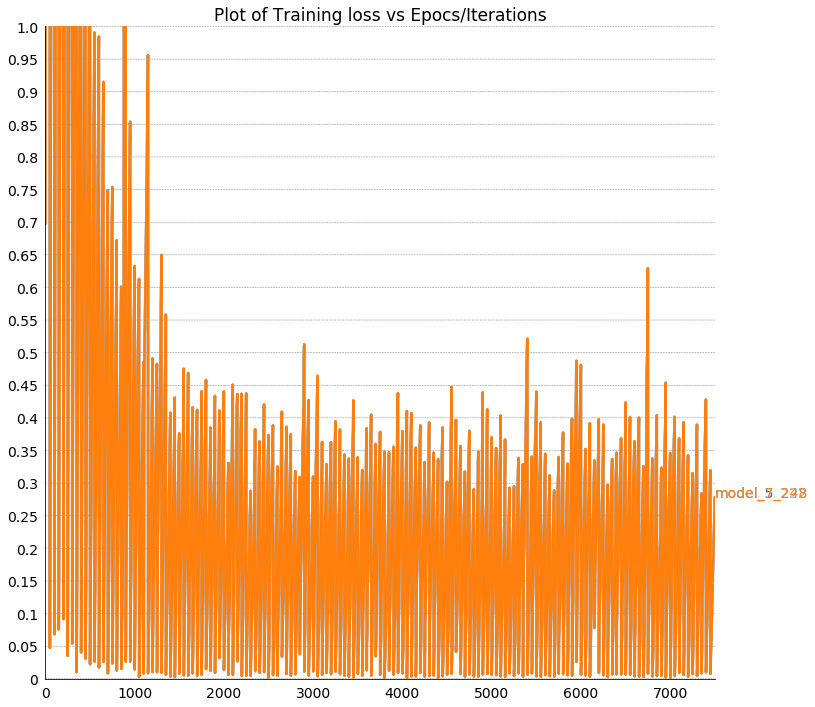

In [51]:
import matplotlib.pyplot as plt  
import pandas as pd  
      
# Read the data into a pandas DataFrame.    
gender_degree_data = losss    
      
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
# exception because of the number of lines being plotted on it.    
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(12, 12))    
  
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
  
# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
plt.ylim(0, 1)    
plt.xlim(0, 7501)    ## epocs

a= [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
plt.yticks(a, [str(x) for x in a], fontsize=14)    
plt.xticks(fontsize=14)    
  
# Provide tick lines across the plot to help your viewers trace along    
# the axis ticks. Make sure that the lines are light and small so they    
# don't obscure the primary data lines.    
for y in a:    
    plt.plot(range(0, 7501), [y] * len(range(0, 7501)), "--", lw=0.5, color="black", alpha=0.5)    

# Remove the tick marks; they are unnecessary with the tick lines we just plotted.    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")    
    
majors = ['model_5_222', 'model_7_222', 'model_7_248']    
  
for rank, column in enumerate(majors):    
    # Plot each line separately with its own color, using the Tableau 20    
    # color set in order.    
    plt.plot(losss.iter.values,    
            losss[column.replace("\n", " ")].values,    
            lw=2.5, color=tableau20[rank])    
  
    # Add a text label to the right end of every line. Most of the code below    
    # is adding specific offsets y position because some labels overlapped.    
    y_pos = losss[column.replace("\n", " ")].values[-1] - 0.5    
    if column == "model_5_222":    
        y_pos += 0.5  
    elif column == "model_7_222":    
        y_pos += 0.5   
    elif column == "model_7_248":    
        y_pos += 0.5
   
    plt.text(7500, y_pos, column, fontsize=14, color=tableau20[rank])    


plt.title("Plot of Training loss vs Epocs/Iterations", fontsize=17)    

plt.savefig("loss-vs-Epocs_150.png", bbox_inches="tight")  

______

______
# **```Thank You :)```**